In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt

import functions

In [2]:
def dataslicercombined(df, hadrons, dependencies):
    '''
    returns X, y, err
    '''
    df = df.loc[df['hadron'].isin(hadrons), :]
    df = df.loc[df['1D_dependence'].isin(dependencies), :]
    X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
    for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
        X[X[:, 4] == had, 4] = i
    X = X.astype('float')
    return X, np.array(df['Siv']), np.array(df['tot_err'])

In [3]:
def chisquare(y, yhat, err):
    return np.sum(((y - yhat)/err)**2)

In [4]:
class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct      
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last

In [5]:
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]

In [6]:
def create_nn(inp, name, hidden_layers=2, width=256, activation='relu'):
    x = tf.keras.layers.Dense(width, activation=activation)(inp)
    for i in range(hidden_layers-1):
        x = tf.keras.layers.Dense(width, activation=activation)(x)
    nnout = tf.keras.layers.Dense(1, name=name)(x)
    return nnout

In [7]:
def createModel():
    x = tf.keras.Input(shape=(1), name='x')
    z = tf.keras.Input(shape=(1), name='z')
    phT = tf.keras.Input(shape=(1), name='phT')
    uexpr = tf.keras.Input(shape=(1), name='uexpr')
    ubarexpr = tf.keras.Input(shape=(1), name='ubarexpr')
    dexpr = tf.keras.Input(shape=(1), name='dexpr')
    dbarexpr = tf.keras.Input(shape=(1), name='dbarexpr')
    sexpr = tf.keras.Input(shape=(1), name='sexpr')
    sbarexpr = tf.keras.Input(shape=(1), name='sbarexpr')

    nnuout = create_nn(x, 'nnu')
    nndout = create_nn(x, 'nnd')
    nnsout = create_nn(x, 'nns')
    nnubarout = create_nn(x, 'nnubar')
    nndbarout = create_nn(x, 'nndbar')
    nnsbarout = create_nn(x, 'nnsbar')

    nncomb = tf.keras.layers.Concatenate()([nnuout, nnubarout, nndout, nndbarout, nnsout, nnsbarout])

    denominator = tf.keras.layers.Add()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])

    exprcomb = tf.keras.layers.Concatenate()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])

    numerator = tf.keras.layers.Dot(axes=1)([nncomb, exprcomb])

    quo = Quotient()([numerator, denominator])

    zpht = tf.keras.layers.Concatenate()([z, phT])
    a0 = A0()(zpht)
    
    siv = tf.keras.layers.Multiply()([a0, quo])

    return tf.keras.Model([x, z, phT, uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr],
                         siv)

In [8]:
sivModel = createModel()

In [43]:
#tf.keras.utils.plot_model(sivModel, '/home/PATH/model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Test sivModel

In [9]:
inputdict = {'x': tf.constant([1., 2.]),
             'z': tf.constant([1., 2.]),
             'phT': tf.constant([1., 2.]),
             'uexpr': tf.constant([1., 2.]),
             'ubarexpr': tf.constant([1., 2.]),
             'dexpr': tf.constant([1., 2.]),
             'dbarexpr': tf.constant([1., 2.]),
             'sexpr': tf.constant([1., 2.]),
             'sbarexpr': tf.constant([1., 2.])}

In [10]:
sivModel(inputdict)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.06390809],
       [-0.21698107]], dtype=float32)>

# Generate Data

In [11]:
herm9 = pd.read_csv('./Data/HERMES_p_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
herm20 = pd.read_csv('./Data/HERMES_p_2020.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp9 = pd.read_csv('./Data/COMPASS_d_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp15 = pd.read_csv('./Data/COMPASS_p_2015.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')

In [12]:
df = pd.concat([herm9, herm20, comp9, comp15])
#df = pd.concat([herm9, herm20])

In [13]:
class DataANN(object):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
                 ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}
    

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])
    
    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])    
    

    def makeData(self, df, hadrons, dependencies):
        
        data = {'x': [],
             'z': [],
             'phT': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        y = []
        err = []
        
        df = df.loc[df['hadron'].isin(hadrons), :]
        df = df.loc[df['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = df.loc[df['hadron'] == had, :]
            y += list(sliced['Siv'])
            err += list(sliced['tot_err'])
            
            x = sliced['x']
            z = sliced['z']
            QQ = sliced['Q2']
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ))

            data['x'] += list(x)
            data['z'] += list(z)
            data['phT'] += list(sliced['phT'])
        
        for key in data.keys():
            data[key] = np.array(data[key])
        
        print(data)
        return data, np.array(y), np.array(err)                      
       

In [14]:
datann = DataANN()

In [15]:
X, y, err = datann.makeData(df, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'z', 'phT'])

{'x': array([0.086   , 0.094   , 0.097   , 0.099   , 0.1     , 0.101   ,
       0.103   , 0.036   , 0.056   , 0.076   , 0.098   , 0.133   ,
       0.186   , 0.275   , 0.109   , 0.106   , 0.1     , 0.093   ,
       0.086   , 0.08    , 0.073   , 0.036   , 0.056   , 0.074   ,
       0.093   , 0.093   , 0.118   , 0.157   , 0.254   , 0.087   ,
       0.094   , 0.098   , 0.1     , 0.101   , 0.101   , 0.102   ,
       0.104   , 0.107   , 0.108   , 0.116   , 0.11    , 0.108   ,
       0.103   , 0.097   , 0.097   , 0.09    , 0.084   , 0.076   ,
       0.037   , 0.039   , 0.041   , 0.042   , 0.044   , 0.046   ,
       0.046   , 0.045   , 0.006469, 0.01059 , 0.01643 , 0.02556 ,
       0.03967 , 0.06255 , 0.1005  , 0.1609  , 0.2781  , 0.043   ,
       0.042   , 0.041   , 0.041   , 0.041   , 0.04    , 0.04    ,
       0.039   , 0.038   , 0.0065  , 0.0106  , 0.0164  , 0.0257  ,
       0.0399  , 0.0628  , 0.1009  , 0.1621  , 0.2881  , 0.0467  ,
       0.0483  , 0.0498  , 0.0511  , 0.0527  , 0.0545  ,

In [16]:
def trn_tst(X, y, err, split=0.1):
    tstidxs = np.random.choice(list(range(len(y))), size=int(len(y)*split), replace=False)
    
    tst_X = {k: v[tstidxs] for k, v in X.items()}
    trn_X = {k: np.delete(v, tstidxs) for k, v in X.items()}
    
    tst_y = y[tstidxs]
    trn_y = np.delete(y, tstidxs)
    
    tst_err = err[tstidxs]
    trn_err = np.delete(err, tstidxs)
    
    return trn_X, tst_X, trn_y, tst_y, trn_err, tst_err

In [17]:
trn_X, tst_X, trn_y, tst_y, trn_err, tst_err = trn_tst(X, y, err)

# Train

In [176]:
sivModel = createModel()

In [18]:
sivModel.compile(
    optimizer = tf.keras.optimizers.Adam(.0001),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [178]:
#sivModel.fit(trn_X, trn_y, sample_weight=(trn_err), validation_data=(tst_X, tst_y), epochs=100,
#             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

sivModel.fit(trn_X, trn_y, sample_weight=(1/trn_err**2), validation_data=(tst_X, tst_y), epochs=5000)

Epoch 1/5000
13/13 [==============================] - 1s 17ms/step - loss: 7.0777 - val_loss: 0.0032
Epoch 2/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.4311 - val_loss: 0.0031
Epoch 3/5000
13/13 [==============================] - 0s 6ms/step - loss: 4.5051 - val_loss: 0.0031
Epoch 4/5000
13/13 [==============================] - 0s 7ms/step - loss: 4.4925 - val_loss: 0.0031
Epoch 5/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.5203 - val_loss: 0.0032
Epoch 6/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.6886 - val_loss: 0.0031
Epoch 7/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.2195 - val_loss: 0.0033
Epoch 8/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.4368 - val_loss: 0.0031
Epoch 9/5000
13/13 [==============================] - 0s 6ms/step - loss: 14.1938 - val_loss: 0.0031
Epoch 10/5000
13/13 [==============================] - 0s 6ms/step - loss: 11.0657 - val_loss: 0.0

13/13 [==============================] - 0s 5ms/step - loss: 4.5392 - val_loss: 0.0030
Epoch 163/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.1522 - val_loss: 0.0031
Epoch 164/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.6254 - val_loss: 0.0030
Epoch 165/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.5455 - val_loss: 0.0031
Epoch 166/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.4711 - val_loss: 0.0030
Epoch 167/5000
13/13 [==============================] - 0s 6ms/step - loss: 3.4464 - val_loss: 0.0030
Epoch 168/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.4304 - val_loss: 0.0030
Epoch 169/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.4287 - val_loss: 0.0030
Epoch 170/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.4152 - val_loss: 0.0030
Epoch 171/5000
13/13 [==============================] - 0s 6ms/step - loss: 3.4384 - val_loss: 0.

13/13 [==============================] - 0s 8ms/step - loss: 3.1239 - val_loss: 0.0028
Epoch 323/5000
13/13 [==============================] - 0s 6ms/step - loss: 3.1196 - val_loss: 0.0029
Epoch 324/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.1163 - val_loss: 0.0029
Epoch 325/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.1133 - val_loss: 0.0029
Epoch 326/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.1091 - val_loss: 0.0029
Epoch 327/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.1050 - val_loss: 0.0029
Epoch 328/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.1014 - val_loss: 0.0029
Epoch 329/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.0981 - val_loss: 0.0029
Epoch 330/5000
13/13 [==============================] - 0s 8ms/step - loss: 3.0940 - val_loss: 0.0029
Epoch 331/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.0912 - val_loss: 0.

13/13 [==============================] - 0s 7ms/step - loss: 2.8297 - val_loss: 0.0027
Epoch 483/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.8539 - val_loss: 0.0028
Epoch 484/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.8435 - val_loss: 0.0028
Epoch 485/5000
13/13 [==============================] - 0s 4ms/step - loss: 2.8081 - val_loss: 0.0028
Epoch 486/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.8194 - val_loss: 0.0028
Epoch 487/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.7952 - val_loss: 0.0028
Epoch 488/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.7833 - val_loss: 0.0028
Epoch 489/5000
13/13 [==============================] - 0s 4ms/step - loss: 2.7863 - val_loss: 0.0028
Epoch 490/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.7778 - val_loss: 0.0028
Epoch 491/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.7744 - val_loss: 0.

13/13 [==============================] - 0s 6ms/step - loss: 7.0288 - val_loss: 0.0028
Epoch 643/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.7909 - val_loss: 0.0032
Epoch 644/5000
13/13 [==============================] - 0s 7ms/step - loss: 12.0131 - val_loss: 0.0031
Epoch 645/5000
13/13 [==============================] - 0s 9ms/step - loss: 3.5082 - val_loss: 0.0026
Epoch 646/5000
13/13 [==============================] - 0s 5ms/step - loss: 92.0463 - val_loss: 0.0026
Epoch 647/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.7766 - val_loss: 0.0033
Epoch 648/5000
13/13 [==============================] - 0s 7ms/step - loss: 47.2770 - val_loss: 0.0030
Epoch 649/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.8268 - val_loss: 0.0026
Epoch 650/5000
13/13 [==============================] - 0s 6ms/step - loss: 10.4219 - val_loss: 0.0026
Epoch 651/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.7390 - val_loss

13/13 [==============================] - 0s 6ms/step - loss: 2.4591 - val_loss: 0.0029
Epoch 803/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.4534 - val_loss: 0.0028
Epoch 804/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.4527 - val_loss: 0.0028
Epoch 805/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.4516 - val_loss: 0.0028
Epoch 806/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.4568 - val_loss: 0.0028
Epoch 807/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.4379 - val_loss: 0.0028
Epoch 808/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.5570 - val_loss: 0.0028
Epoch 809/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.5884 - val_loss: 0.0028
Epoch 810/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.4425 - val_loss: 0.0028
Epoch 811/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.4671 - val_loss: 0.

13/13 [==============================] - 0s 7ms/step - loss: 2.3226 - val_loss: 0.0026
Epoch 963/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3207 - val_loss: 0.0026
Epoch 964/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3190 - val_loss: 0.0026
Epoch 965/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3172 - val_loss: 0.0026
Epoch 966/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.3170 - val_loss: 0.0026
Epoch 967/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.3143 - val_loss: 0.0026
Epoch 968/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3115 - val_loss: 0.0026
Epoch 969/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3101 - val_loss: 0.0026
Epoch 970/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3132 - val_loss: 0.0026
Epoch 971/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.3059 - val_loss: 0.

13/13 [==============================] - 0s 7ms/step - loss: 2.2456 - val_loss: 0.0025
Epoch 1043/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2446 - val_loss: 0.0025
Epoch 1044/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2429 - val_loss: 0.0025
Epoch 1045/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2409 - val_loss: 0.0025
Epoch 1046/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2398 - val_loss: 0.0025
Epoch 1047/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2381 - val_loss: 0.0025
Epoch 1048/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2362 - val_loss: 0.0025
Epoch 1049/5000
13/13 [==============================] - 0s 11ms/step - loss: 2.2359 - val_loss: 0.0025
Epoch 1050/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2350 - val_loss: 0.0025
Epoch 1051/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2335 - va

13/13 [==============================] - 0s 7ms/step - loss: 2.1760 - val_loss: 0.0025
Epoch 1201/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1754 - val_loss: 0.0025
Epoch 1202/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1732 - val_loss: 0.0025
Epoch 1203/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1744 - val_loss: 0.0025
Epoch 1204/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1713 - val_loss: 0.0024
Epoch 1205/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1702 - val_loss: 0.0025
Epoch 1206/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1696 - val_loss: 0.0025
Epoch 1207/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1676 - val_loss: 0.0025
Epoch 1208/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1656 - val_loss: 0.0025
Epoch 1209/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1642 - val

13/13 [==============================] - 0s 8ms/step - loss: 2.1755 - val_loss: 0.0024
Epoch 1359/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1671 - val_loss: 0.0024
Epoch 1360/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1234 - val_loss: 0.0024
Epoch 1361/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1164 - val_loss: 0.0024
Epoch 1362/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1162 - val_loss: 0.0024
Epoch 1363/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1125 - val_loss: 0.0024
Epoch 1364/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1110 - val_loss: 0.0024
Epoch 1365/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1108 - val_loss: 0.0024
Epoch 1366/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1132 - val_loss: 0.0024
Epoch 1367/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1176 - val

13/13 [==============================] - 0s 5ms/step - loss: 2.1675 - val_loss: 0.0024
Epoch 1517/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2584 - val_loss: 0.0025
Epoch 1518/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.2406 - val_loss: 0.0024
Epoch 1519/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1992 - val_loss: 0.0025
Epoch 1520/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1894 - val_loss: 0.0024
Epoch 1521/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2255 - val_loss: 0.0025
Epoch 1522/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1845 - val_loss: 0.0025
Epoch 1523/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.1703 - val_loss: 0.0024
Epoch 1524/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1778 - val_loss: 0.0024
Epoch 1525/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1635 - val

13/13 [==============================] - 0s 6ms/step - loss: 2.0848 - val_loss: 0.0023
Epoch 1675/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0762 - val_loss: 0.0024
Epoch 1676/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.1180 - val_loss: 0.0023
Epoch 1677/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0868 - val_loss: 0.0023
Epoch 1678/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0767 - val_loss: 0.0024
Epoch 1679/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0760 - val_loss: 0.0024
Epoch 1680/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.0745 - val_loss: 0.0024
Epoch 1681/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0708 - val_loss: 0.0024
Epoch 1682/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0707 - val_loss: 0.0024
Epoch 1683/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0700 - val

13/13 [==============================] - 0s 9ms/step - loss: 2.0703 - val_loss: 0.0024
Epoch 1833/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0747 - val_loss: 0.0024
Epoch 1834/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0729 - val_loss: 0.0024
Epoch 1835/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0706 - val_loss: 0.0024
Epoch 1836/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0576 - val_loss: 0.0024
Epoch 1837/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0457 - val_loss: 0.0023
Epoch 1838/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0434 - val_loss: 0.0024
Epoch 1839/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.0437 - val_loss: 0.0024
Epoch 1840/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0429 - val_loss: 0.0023
Epoch 1841/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0432 - val

13/13 [==============================] - 0s 8ms/step - loss: 2.0909 - val_loss: 0.0024
Epoch 1991/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0794 - val_loss: 0.0024
Epoch 1992/5000
13/13 [==============================] - 0s 10ms/step - loss: 2.0296 - val_loss: 0.0024
Epoch 1993/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0361 - val_loss: 0.0023
Epoch 1994/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0466 - val_loss: 0.0024
Epoch 1995/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.0472 - val_loss: 0.0024
Epoch 1996/5000
13/13 [==============================] - 0s 11ms/step - loss: 2.0429 - val_loss: 0.0024
Epoch 1997/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0306 - val_loss: 0.0023
Epoch 1998/5000
13/13 [==============================] - 0s 11ms/step - loss: 2.0222 - val_loss: 0.0023
Epoch 1999/5000
13/13 [==============================] - 0s 10ms/step - loss: 2.0229 -

13/13 [==============================] - 0s 8ms/step - loss: 2.0161 - val_loss: 0.0022
Epoch 2149/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0140 - val_loss: 0.0022
Epoch 2150/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0129 - val_loss: 0.0022
Epoch 2151/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0118 - val_loss: 0.0022
Epoch 2152/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.0106 - val_loss: 0.0022
Epoch 2153/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0105 - val_loss: 0.0022
Epoch 2154/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0089 - val_loss: 0.0022
Epoch 2155/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.0091 - val_loss: 0.0022
Epoch 2156/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0085 - val_loss: 0.0022
Epoch 2157/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0103 - val

13/13 [==============================] - 0s 9ms/step - loss: 1.9936 - val_loss: 0.0023
Epoch 2307/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9925 - val_loss: 0.0023
Epoch 2308/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9909 - val_loss: 0.0023
Epoch 2309/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9898 - val_loss: 0.0023
Epoch 2310/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9927 - val_loss: 0.0023
Epoch 2311/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9900 - val_loss: 0.0023
Epoch 2312/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.9889 - val_loss: 0.0023
Epoch 2313/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9889 - val_loss: 0.0023
Epoch 2314/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9893 - val_loss: 0.0023
Epoch 2315/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.9892 - val

13/13 [==============================] - 0s 7ms/step - loss: 1.9856 - val_loss: 0.0022
Epoch 2465/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0724 - val_loss: 0.0022
Epoch 2466/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.3396 - val_loss: 0.0022
Epoch 2467/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0672 - val_loss: 0.0022
Epoch 2468/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.2754 - val_loss: 0.0022
Epoch 2469/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.4901 - val_loss: 0.0023
Epoch 2470/5000
13/13 [==============================] - 0s 5ms/step - loss: 3.2102 - val_loss: 0.0022
Epoch 2471/5000
13/13 [==============================] - 0s 7ms/step - loss: 4.9698 - val_loss: 0.0023
Epoch 2472/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.7072 - val_loss: 0.0022
Epoch 2473/5000
13/13 [==============================] - 0s 8ms/step - loss: 9.6718 - val

13/13 [==============================] - 0s 5ms/step - loss: 2.7146 - val_loss: 0.0022
Epoch 2623/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9528 - val_loss: 0.0022
Epoch 2624/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.1157 - val_loss: 0.0022
Epoch 2625/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.9643 - val_loss: 0.0022
Epoch 2626/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.1109 - val_loss: 0.0022
Epoch 2627/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.1245 - val_loss: 0.0022
Epoch 2628/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0067 - val_loss: 0.0022
Epoch 2629/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.9593 - val_loss: 0.0022
Epoch 2630/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9544 - val_loss: 0.0022
Epoch 2631/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9563 - val

13/13 [==============================] - 0s 7ms/step - loss: 5.0753 - val_loss: 0.0022
Epoch 2781/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.0699 - val_loss: 0.0022
Epoch 2782/5000
13/13 [==============================] - 0s 4ms/step - loss: 12.1988 - val_loss: 0.0022
Epoch 2783/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.7941 - val_loss: 0.0027
Epoch 2784/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3748 - val_loss: 0.0026
Epoch 2785/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.2006 - val_loss: 0.0027
Epoch 2786/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.9831 - val_loss: 0.0025
Epoch 2787/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.5470 - val_loss: 0.0025
Epoch 2788/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1005 - val_loss: 0.0025
Epoch 2789/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0225 - va

13/13 [==============================] - 0s 8ms/step - loss: 1.9707 - val_loss: 0.0021
Epoch 2939/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0973 - val_loss: 0.0021
Epoch 2940/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9528 - val_loss: 0.0022
Epoch 2941/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1824 - val_loss: 0.0021
Epoch 2942/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.8798 - val_loss: 0.0022
Epoch 2943/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.4488 - val_loss: 0.0021
Epoch 2944/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.5375 - val_loss: 0.0021
Epoch 2945/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9456 - val_loss: 0.0021
Epoch 2946/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9392 - val_loss: 0.0021
Epoch 2947/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9511 - val

13/13 [==============================] - 0s 7ms/step - loss: 1.9183 - val_loss: 0.0022
Epoch 3097/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9175 - val_loss: 0.0022
Epoch 3098/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9191 - val_loss: 0.0022
Epoch 3099/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9193 - val_loss: 0.0022
Epoch 3100/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9138 - val_loss: 0.0022
Epoch 3101/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9213 - val_loss: 0.0022
Epoch 3102/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.9284 - val_loss: 0.0021
Epoch 3103/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9671 - val_loss: 0.0021
Epoch 3104/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0444 - val_loss: 0.0022
Epoch 3105/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9663 - val

13/13 [==============================] - 0s 8ms/step - loss: 4.3878 - val_loss: 0.0022
Epoch 3255/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9978 - val_loss: 0.0021
Epoch 3256/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.2017 - val_loss: 0.0023
Epoch 3257/5000
13/13 [==============================] - 0s 7ms/step - loss: 13.5833 - val_loss: 0.0024
Epoch 3258/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.9228 - val_loss: 0.0023
Epoch 3259/5000
13/13 [==============================] - 0s 8ms/step - loss: 69.4559 - val_loss: 0.0021
Epoch 3260/5000
13/13 [==============================] - 0s 6ms/step - loss: 4.5643 - val_loss: 0.0022
Epoch 3261/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.8206 - val_loss: 0.0021
Epoch 3262/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1885 - val_loss: 0.0021
Epoch 3263/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0250 - v

13/13 [==============================] - 0s 5ms/step - loss: 1.9074 - val_loss: 0.0021
Epoch 3413/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9069 - val_loss: 0.0021
Epoch 3414/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9060 - val_loss: 0.0021
Epoch 3415/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9068 - val_loss: 0.0021
Epoch 3416/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9067 - val_loss: 0.0021
Epoch 3417/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9067 - val_loss: 0.0021
Epoch 3418/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.9066 - val_loss: 0.0021
Epoch 3419/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9042 - val_loss: 0.0021
Epoch 3420/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9047 - val_loss: 0.0021
Epoch 3421/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.9034 - va

13/13 [==============================] - 0s 7ms/step - loss: 1.8936 - val_loss: 0.0021
Epoch 3571/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8926 - val_loss: 0.0021
Epoch 3572/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8940 - val_loss: 0.0021
Epoch 3573/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8936 - val_loss: 0.0021
Epoch 3574/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8949 - val_loss: 0.0021
Epoch 3575/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.9052 - val_loss: 0.0021
Epoch 3576/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9187 - val_loss: 0.0021
Epoch 3577/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9158 - val_loss: 0.0021
Epoch 3578/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9134 - val_loss: 0.0021
Epoch 3579/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8919 - val

13/13 [==============================] - 0s 9ms/step - loss: 1.8885 - val_loss: 0.0021
Epoch 3729/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8875 - val_loss: 0.0021
Epoch 3730/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8888 - val_loss: 0.0021
Epoch 3731/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.8930 - val_loss: 0.0021
Epoch 3732/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8883 - val_loss: 0.0021
Epoch 3733/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8893 - val_loss: 0.0021
Epoch 3734/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8930 - val_loss: 0.0021
Epoch 3735/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8867 - val_loss: 0.0021
Epoch 3736/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8875 - val_loss: 0.0021
Epoch 3737/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8858 - val

13/13 [==============================] - 0s 8ms/step - loss: 1.8705 - val_loss: 0.0021
Epoch 3887/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8725 - val_loss: 0.0021
Epoch 3888/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8803 - val_loss: 0.0021
Epoch 3889/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.8761 - val_loss: 0.0021
Epoch 3890/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8721 - val_loss: 0.0021
Epoch 3891/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8741 - val_loss: 0.0021
Epoch 3892/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8893 - val_loss: 0.0021
Epoch 3893/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9774 - val_loss: 0.0021
Epoch 3894/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1964 - val_loss: 0.0021
Epoch 3895/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3316 - val

13/13 [==============================] - 0s 7ms/step - loss: 1.8628 - val_loss: 0.0021
Epoch 4045/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.8650 - val_loss: 0.0021
Epoch 4046/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8685 - val_loss: 0.0021
Epoch 4047/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8669 - val_loss: 0.0021
Epoch 4048/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8599 - val_loss: 0.0021
Epoch 4049/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8603 - val_loss: 0.0021
Epoch 4050/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8666 - val_loss: 0.0021
Epoch 4051/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8893 - val_loss: 0.0021
Epoch 4052/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8775 - val_loss: 0.0021
Epoch 4053/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8599 - va

13/13 [==============================] - 0s 8ms/step - loss: 1.8692 - val_loss: 0.0021
Epoch 4203/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8704 - val_loss: 0.0021
Epoch 4204/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.8734 - val_loss: 0.0020
Epoch 4205/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.8689 - val_loss: 0.0020
Epoch 4206/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8677 - val_loss: 0.0021
Epoch 4207/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.8664 - val_loss: 0.0020
Epoch 4208/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8659 - val_loss: 0.0020
Epoch 4209/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8665 - val_loss: 0.0021
Epoch 4210/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8667 - val_loss: 0.0020
Epoch 4211/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8663 - v

13/13 [==============================] - 0s 8ms/step - loss: 1.8574 - val_loss: 0.0021
Epoch 4361/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8559 - val_loss: 0.0021
Epoch 4362/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8549 - val_loss: 0.0020
Epoch 4363/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8562 - val_loss: 0.0021
Epoch 4364/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.8591 - val_loss: 0.0020
Epoch 4365/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8533 - val_loss: 0.0021
Epoch 4366/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8582 - val_loss: 0.0021
Epoch 4367/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8582 - val_loss: 0.0021
Epoch 4368/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8605 - val_loss: 0.0021
Epoch 4369/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8576 - val

13/13 [==============================] - 0s 8ms/step - loss: 1.8476 - val_loss: 0.0020
Epoch 4519/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8492 - val_loss: 0.0020
Epoch 4520/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8525 - val_loss: 0.0020
Epoch 4521/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.8534 - val_loss: 0.0020
Epoch 4522/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8475 - val_loss: 0.0020
Epoch 4523/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8504 - val_loss: 0.0020
Epoch 4524/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8514 - val_loss: 0.0020
Epoch 4525/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8546 - val_loss: 0.0020
Epoch 4526/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8491 - val_loss: 0.0020
Epoch 4527/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8499 - va

13/13 [==============================] - 0s 8ms/step - loss: 1.8327 - val_loss: 0.0020
Epoch 4677/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8322 - val_loss: 0.0020
Epoch 4678/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8344 - val_loss: 0.0020
Epoch 4679/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8357 - val_loss: 0.0020
Epoch 4680/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8377 - val_loss: 0.0020
Epoch 4681/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8338 - val_loss: 0.0020
Epoch 4682/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8297 - val_loss: 0.0020
Epoch 4683/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8310 - val_loss: 0.0020
Epoch 4684/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8279 - val_loss: 0.0020
Epoch 4685/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8305 - val

13/13 [==============================] - 0s 7ms/step - loss: 1.9198 - val_loss: 0.0020
Epoch 4835/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8255 - val_loss: 0.0020
Epoch 4836/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8340 - val_loss: 0.0020
Epoch 4837/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8712 - val_loss: 0.0020
Epoch 4838/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8858 - val_loss: 0.0020
Epoch 4839/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.9175 - val_loss: 0.0020
Epoch 4840/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9372 - val_loss: 0.0020
Epoch 4841/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0391 - val_loss: 0.0020
Epoch 4842/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0947 - val_loss: 0.0020
Epoch 4843/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9962 - val

13/13 [==============================] - 0s 7ms/step - loss: 1.8490 - val_loss: 0.0020
Epoch 4993/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8607 - val_loss: 0.0020
Epoch 4994/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8521 - val_loss: 0.0020
Epoch 4995/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8515 - val_loss: 0.0020
Epoch 4996/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8384 - val_loss: 0.0020
Epoch 4997/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8350 - val_loss: 0.0020
Epoch 4998/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8349 - val_loss: 0.0020
Epoch 4999/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8341 - val_loss: 0.0020
Epoch 5000/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8342 - val_loss: 0.0020


## M1

In [19]:
sivModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          512         x[0][0]                          
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          512         x[0][0]                          
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          512         x[0][0]                          
______________________________________________________________________________________________

In [21]:
sivModel.get_layer('a0').get_weights()

[1.0]

# Validation $\chi^2/dof$

In [181]:
def calc_yhat(model, X):
    return np.array([x[0] for x in model.predict(X)])

In [182]:
yhat = calc_yhat(sivModel, tst_X)

In [183]:
chisquare(tst_y, yhat, tst_err)/len(yhat)

3.099498061101501

### On training data

In [184]:
yhat = calc_yhat(sivModel, trn_X)
chisquare(trn_y, yhat, trn_err)/len(yhat)

1.8309534926454627

In [192]:
sivModel.save('Models/SIDIStest.h5', save_format='h5')

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Plot

{'x': array([0.036   , 0.056   , 0.076   , 0.098   , 0.133   , 0.186   ,
       0.275   , 0.036   , 0.056   , 0.074   , 0.093   , 0.093   ,
       0.118   , 0.157   , 0.254   , 0.006469, 0.01059 , 0.01643 ,
       0.02556 , 0.03967 , 0.06255 , 0.1005  , 0.1609  , 0.2781  ,
       0.0065  , 0.0106  , 0.0164  , 0.0257  , 0.0399  , 0.0628  ,
       0.1009  , 0.1621  , 0.2881  ]), 'z': array([0.336, 0.356, 0.367, 0.376, 0.379, 0.379, 0.375, 0.336, 0.356,
       0.366, 0.374, 0.374, 0.379, 0.379, 0.375, 0.29 , 0.33 , 0.35 ,
       0.37 , 0.39 , 0.38 , 0.37 , 0.37 , 0.36 , 0.285, 0.321, 0.347,
       0.363, 0.37 , 0.367, 0.365, 0.362, 0.361]), 'phT': array([0.489, 0.409, 0.372, 0.356, 0.344, 0.339, 0.344, 0.486, 0.408,
       0.375, 0.358, 0.358, 0.348, 0.342, 0.343, 0.53 , 0.52 , 0.49 ,
       0.46 , 0.45 , 0.46 , 0.46 , 0.47 , 0.51 , 0.54 , 0.52 , 0.51 ,
       0.49 , 0.48 , 0.48 , 0.48 , 0.48 , 0.52 ]), 'uexpr': array([0.1439757 , 0.16635226, 0.1745903 , 0.17779312, 0.18127628,
       0.1

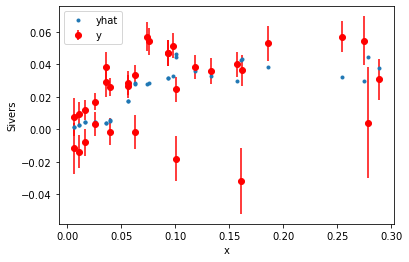

In [185]:
Xplt, yplt, errplt = datann.makeData(df, ['pi+'], ['x'])

yhatplt = calc_yhat(sivModel, Xplt)

plt.plot(Xplt['x'], yhatplt,'.', label='yhat')
plt.errorbar(Xplt['x'], yplt, yerr=errplt, fmt='ro', label='y')
plt.legend()
plt.ylabel('Sivers')
plt.xlabel('x')
plt.show()

In [22]:
def trainReplicas(X, y, err, numReplicas):
    for i in range(numReplicas):
        yrep = np.random.normal(y, err)
        
        sivModel = createModel()
        
        sivModel.compile(
            optimizer = tf.keras.optimizers.Adam(.0001),
            loss = tf.keras.losses.MeanSquaredError()
            )
        
        #sivModel.fit(X, yrep, epochs=50, verbose=2)
        sivModel.fit(X, y, sample_weight=(1/trn_err**2), validation_data=(tst_X, tst_y), epochs=5000, verbose=2)
        
        sivModel.save('Models_SIDIS_100/rep' + str(i) + '.h5', save_format='h5')

In [24]:
trainReplicas(trn_X, trn_y, trn_err, 10)

Epoch 1/5000
13/13 - 1s - loss: 6.6779 - val_loss: 0.0026
Epoch 2/5000
13/13 - 0s - loss: 11.9854 - val_loss: 0.0019
Epoch 3/5000
13/13 - 0s - loss: 7.5702 - val_loss: 0.0019
Epoch 4/5000
13/13 - 0s - loss: 5.5016 - val_loss: 0.0019
Epoch 5/5000
13/13 - 0s - loss: 5.4876 - val_loss: 0.0019
Epoch 6/5000
13/13 - 0s - loss: 5.4089 - val_loss: 0.0019
Epoch 7/5000
13/13 - 0s - loss: 5.4349 - val_loss: 0.0020
Epoch 8/5000
13/13 - 0s - loss: 5.3378 - val_loss: 0.0020
Epoch 9/5000
13/13 - 0s - loss: 5.3869 - val_loss: 0.0020
Epoch 10/5000
13/13 - 0s - loss: 5.3439 - val_loss: 0.0020
Epoch 11/5000
13/13 - 0s - loss: 5.2760 - val_loss: 0.0020
Epoch 12/5000
13/13 - 0s - loss: 5.1627 - val_loss: 0.0020
Epoch 13/5000
13/13 - 0s - loss: 5.4281 - val_loss: 0.0020
Epoch 14/5000
13/13 - 0s - loss: 5.2623 - val_loss: 0.0020
Epoch 15/5000
13/13 - 0s - loss: 5.0266 - val_loss: 0.0021
Epoch 16/5000
13/13 - 0s - loss: 4.9718 - val_loss: 0.0021
Epoch 17/5000
13/13 - 0s - loss: 5.1202 - val_loss: 0.0021
Epoch

Epoch 140/5000
13/13 - 0s - loss: 4.4390 - val_loss: 0.0021
Epoch 141/5000
13/13 - 0s - loss: 3.8628 - val_loss: 0.0021
Epoch 142/5000
13/13 - 0s - loss: 3.8732 - val_loss: 0.0021
Epoch 143/5000
13/13 - 0s - loss: 3.9820 - val_loss: 0.0022
Epoch 144/5000
13/13 - 0s - loss: 3.8941 - val_loss: 0.0021
Epoch 145/5000
13/13 - 0s - loss: 3.9110 - val_loss: 0.0021
Epoch 146/5000
13/13 - 0s - loss: 3.9251 - val_loss: 0.0021
Epoch 147/5000
13/13 - 0s - loss: 3.8205 - val_loss: 0.0021
Epoch 148/5000
13/13 - 0s - loss: 3.8610 - val_loss: 0.0022
Epoch 149/5000
13/13 - 0s - loss: 3.8970 - val_loss: 0.0021
Epoch 150/5000
13/13 - 0s - loss: 3.8270 - val_loss: 0.0021
Epoch 151/5000
13/13 - 0s - loss: 4.0204 - val_loss: 0.0022
Epoch 152/5000
13/13 - 0s - loss: 4.1358 - val_loss: 0.0022
Epoch 153/5000
13/13 - 0s - loss: 3.8223 - val_loss: 0.0021
Epoch 154/5000
13/13 - 0s - loss: 3.8195 - val_loss: 0.0021
Epoch 155/5000
13/13 - 0s - loss: 3.7615 - val_loss: 0.0022
Epoch 156/5000
13/13 - 0s - loss: 3.9978

Epoch 277/5000
13/13 - 0s - loss: 3.3168 - val_loss: 0.0021
Epoch 278/5000
13/13 - 0s - loss: 3.3126 - val_loss: 0.0021
Epoch 279/5000
13/13 - 0s - loss: 3.3095 - val_loss: 0.0021
Epoch 280/5000
13/13 - 0s - loss: 3.3040 - val_loss: 0.0021
Epoch 281/5000
13/13 - 0s - loss: 3.3000 - val_loss: 0.0021
Epoch 282/5000
13/13 - 0s - loss: 3.2962 - val_loss: 0.0021
Epoch 283/5000
13/13 - 0s - loss: 3.2924 - val_loss: 0.0021
Epoch 284/5000
13/13 - 0s - loss: 3.2897 - val_loss: 0.0021
Epoch 285/5000
13/13 - 0s - loss: 3.2882 - val_loss: 0.0021
Epoch 286/5000
13/13 - 0s - loss: 3.2831 - val_loss: 0.0021
Epoch 287/5000
13/13 - 0s - loss: 3.3042 - val_loss: 0.0021
Epoch 288/5000
13/13 - 0s - loss: 3.2983 - val_loss: 0.0021
Epoch 289/5000
13/13 - 0s - loss: 3.3553 - val_loss: 0.0021
Epoch 290/5000
13/13 - 0s - loss: 3.3268 - val_loss: 0.0021
Epoch 291/5000
13/13 - 0s - loss: 3.2701 - val_loss: 0.0021
Epoch 292/5000
13/13 - 0s - loss: 3.2722 - val_loss: 0.0021
Epoch 293/5000
13/13 - 0s - loss: 3.2746

Epoch 414/5000
13/13 - 0s - loss: 3.6909 - val_loss: 0.0020
Epoch 415/5000
13/13 - 0s - loss: 3.0420 - val_loss: 0.0021
Epoch 416/5000
13/13 - 0s - loss: 3.4435 - val_loss: 0.0020
Epoch 417/5000
13/13 - 0s - loss: 4.2097 - val_loss: 0.0023
Epoch 418/5000
13/13 - 0s - loss: 6.2561 - val_loss: 0.0020
Epoch 419/5000
13/13 - 0s - loss: 3.1327 - val_loss: 0.0027
Epoch 420/5000
13/13 - 0s - loss: 10.2475 - val_loss: 0.0022
Epoch 421/5000
13/13 - 0s - loss: 16.5734 - val_loss: 0.0020
Epoch 422/5000
13/13 - 0s - loss: 10.8424 - val_loss: 0.0020
Epoch 423/5000
13/13 - 0s - loss: 5.5282 - val_loss: 0.0022
Epoch 424/5000
13/13 - 0s - loss: 3.0709 - val_loss: 0.0020
Epoch 425/5000
13/13 - 0s - loss: 4.5027 - val_loss: 0.0020
Epoch 426/5000
13/13 - 0s - loss: 3.5067 - val_loss: 0.0019
Epoch 427/5000
13/13 - 0s - loss: 3.0298 - val_loss: 0.0019
Epoch 428/5000
13/13 - 0s - loss: 3.0045 - val_loss: 0.0019
Epoch 429/5000
13/13 - 0s - loss: 3.0031 - val_loss: 0.0019
Epoch 430/5000
13/13 - 0s - loss: 2.9

Epoch 551/5000
13/13 - 0s - loss: 2.7528 - val_loss: 0.0019
Epoch 552/5000
13/13 - 0s - loss: 2.7527 - val_loss: 0.0019
Epoch 553/5000
13/13 - 0s - loss: 2.7476 - val_loss: 0.0019
Epoch 554/5000
13/13 - 0s - loss: 2.7449 - val_loss: 0.0019
Epoch 555/5000
13/13 - 0s - loss: 2.7428 - val_loss: 0.0019
Epoch 556/5000
13/13 - 0s - loss: 2.7406 - val_loss: 0.0019
Epoch 557/5000
13/13 - 0s - loss: 2.7422 - val_loss: 0.0019
Epoch 558/5000
13/13 - 0s - loss: 2.7574 - val_loss: 0.0019
Epoch 559/5000
13/13 - 0s - loss: 2.8290 - val_loss: 0.0019
Epoch 560/5000
13/13 - 0s - loss: 2.8826 - val_loss: 0.0019
Epoch 561/5000
13/13 - 0s - loss: 3.0115 - val_loss: 0.0019
Epoch 562/5000
13/13 - 0s - loss: 3.4683 - val_loss: 0.0019
Epoch 563/5000
13/13 - 0s - loss: 2.9096 - val_loss: 0.0019
Epoch 564/5000
13/13 - 0s - loss: 2.8675 - val_loss: 0.0020
Epoch 565/5000
13/13 - 0s - loss: 3.1235 - val_loss: 0.0019
Epoch 566/5000
13/13 - 0s - loss: 3.7045 - val_loss: 0.0019
Epoch 567/5000
13/13 - 0s - loss: 4.0519

Epoch 688/5000
13/13 - 0s - loss: 2.5858 - val_loss: 0.0018
Epoch 689/5000
13/13 - 0s - loss: 2.6260 - val_loss: 0.0018
Epoch 690/5000
13/13 - 0s - loss: 2.5840 - val_loss: 0.0018
Epoch 691/5000
13/13 - 0s - loss: 2.5626 - val_loss: 0.0018
Epoch 692/5000
13/13 - 0s - loss: 2.5614 - val_loss: 0.0018
Epoch 693/5000
13/13 - 0s - loss: 2.5607 - val_loss: 0.0018
Epoch 694/5000
13/13 - 0s - loss: 2.5592 - val_loss: 0.0018
Epoch 695/5000
13/13 - 0s - loss: 2.5565 - val_loss: 0.0018
Epoch 696/5000
13/13 - 0s - loss: 2.5565 - val_loss: 0.0018
Epoch 697/5000
13/13 - 0s - loss: 2.5532 - val_loss: 0.0018
Epoch 698/5000
13/13 - 0s - loss: 2.5538 - val_loss: 0.0018
Epoch 699/5000
13/13 - 0s - loss: 2.5543 - val_loss: 0.0018
Epoch 700/5000
13/13 - 0s - loss: 2.5626 - val_loss: 0.0018
Epoch 701/5000
13/13 - 0s - loss: 2.5923 - val_loss: 0.0018
Epoch 702/5000
13/13 - 0s - loss: 2.6947 - val_loss: 0.0018
Epoch 703/5000
13/13 - 0s - loss: 2.8691 - val_loss: 0.0018
Epoch 704/5000
13/13 - 0s - loss: 2.7550

Epoch 825/5000
13/13 - 0s - loss: 2.4460 - val_loss: 0.0017
Epoch 826/5000
13/13 - 0s - loss: 2.4422 - val_loss: 0.0017
Epoch 827/5000
13/13 - 0s - loss: 2.4393 - val_loss: 0.0017
Epoch 828/5000
13/13 - 0s - loss: 2.4391 - val_loss: 0.0017
Epoch 829/5000
13/13 - 0s - loss: 2.4367 - val_loss: 0.0017
Epoch 830/5000
13/13 - 0s - loss: 2.4337 - val_loss: 0.0017
Epoch 831/5000
13/13 - 0s - loss: 2.4318 - val_loss: 0.0017
Epoch 832/5000
13/13 - 0s - loss: 2.4331 - val_loss: 0.0017
Epoch 833/5000
13/13 - 0s - loss: 2.4267 - val_loss: 0.0017
Epoch 834/5000
13/13 - 0s - loss: 2.4266 - val_loss: 0.0017
Epoch 835/5000
13/13 - 0s - loss: 2.4267 - val_loss: 0.0017
Epoch 836/5000
13/13 - 0s - loss: 2.4229 - val_loss: 0.0017
Epoch 837/5000
13/13 - 0s - loss: 2.4229 - val_loss: 0.0017
Epoch 838/5000
13/13 - 0s - loss: 2.4231 - val_loss: 0.0017
Epoch 839/5000
13/13 - 0s - loss: 2.4169 - val_loss: 0.0017
Epoch 840/5000
13/13 - 0s - loss: 2.4192 - val_loss: 0.0017
Epoch 841/5000
13/13 - 0s - loss: 2.4211

Epoch 962/5000
13/13 - 0s - loss: 3.4565 - val_loss: 0.0018
Epoch 963/5000
13/13 - 0s - loss: 2.8560 - val_loss: 0.0016
Epoch 964/5000
13/13 - 0s - loss: 3.0263 - val_loss: 0.0016
Epoch 965/5000
13/13 - 0s - loss: 2.4610 - val_loss: 0.0019
Epoch 966/5000
13/13 - 0s - loss: 3.8720 - val_loss: 0.0018
Epoch 967/5000
13/13 - 0s - loss: 2.4455 - val_loss: 0.0018
Epoch 968/5000
13/13 - 0s - loss: 5.4226 - val_loss: 0.0017
Epoch 969/5000
13/13 - 0s - loss: 4.5252 - val_loss: 0.0019
Epoch 970/5000
13/13 - 0s - loss: 2.6336 - val_loss: 0.0019
Epoch 971/5000
13/13 - 0s - loss: 6.5303 - val_loss: 0.0016
Epoch 972/5000
13/13 - 0s - loss: 2.6315 - val_loss: 0.0019
Epoch 973/5000
13/13 - 0s - loss: 3.5475 - val_loss: 0.0016
Epoch 974/5000
13/13 - 0s - loss: 2.7592 - val_loss: 0.0016
Epoch 975/5000
13/13 - 0s - loss: 2.3795 - val_loss: 0.0016
Epoch 976/5000
13/13 - 0s - loss: 2.3886 - val_loss: 0.0016
Epoch 977/5000
13/13 - 0s - loss: 2.3788 - val_loss: 0.0016
Epoch 978/5000
13/13 - 0s - loss: 2.3741

Epoch 1097/5000
13/13 - 0s - loss: 2.2914 - val_loss: 0.0016
Epoch 1098/5000
13/13 - 0s - loss: 2.2966 - val_loss: 0.0016
Epoch 1099/5000
13/13 - 0s - loss: 2.3206 - val_loss: 0.0016
Epoch 1100/5000
13/13 - 0s - loss: 2.3105 - val_loss: 0.0016
Epoch 1101/5000
13/13 - 0s - loss: 2.2880 - val_loss: 0.0016
Epoch 1102/5000
13/13 - 0s - loss: 2.2878 - val_loss: 0.0016
Epoch 1103/5000
13/13 - 0s - loss: 2.2895 - val_loss: 0.0016
Epoch 1104/5000
13/13 - 0s - loss: 2.2959 - val_loss: 0.0017
Epoch 1105/5000
13/13 - 0s - loss: 2.3104 - val_loss: 0.0016
Epoch 1106/5000
13/13 - 0s - loss: 2.2895 - val_loss: 0.0016
Epoch 1107/5000
13/13 - 0s - loss: 2.2944 - val_loss: 0.0017
Epoch 1108/5000
13/13 - 0s - loss: 2.3328 - val_loss: 0.0016
Epoch 1109/5000
13/13 - 0s - loss: 2.3729 - val_loss: 0.0017
Epoch 1110/5000
13/13 - 0s - loss: 2.4650 - val_loss: 0.0017
Epoch 1111/5000
13/13 - 0s - loss: 2.3737 - val_loss: 0.0016
Epoch 1112/5000
13/13 - 0s - loss: 2.2823 - val_loss: 0.0017
Epoch 1113/5000
13/13 - 

Epoch 1232/5000
13/13 - 0s - loss: 2.3255 - val_loss: 0.0016
Epoch 1233/5000
13/13 - 0s - loss: 2.2481 - val_loss: 0.0016
Epoch 1234/5000
13/13 - 0s - loss: 2.2408 - val_loss: 0.0016
Epoch 1235/5000
13/13 - 0s - loss: 2.2400 - val_loss: 0.0016
Epoch 1236/5000
13/13 - 0s - loss: 2.2376 - val_loss: 0.0016
Epoch 1237/5000
13/13 - 0s - loss: 2.2399 - val_loss: 0.0016
Epoch 1238/5000
13/13 - 0s - loss: 2.2383 - val_loss: 0.0016
Epoch 1239/5000
13/13 - 0s - loss: 2.2354 - val_loss: 0.0016
Epoch 1240/5000
13/13 - 0s - loss: 2.2370 - val_loss: 0.0016
Epoch 1241/5000
13/13 - 0s - loss: 2.2460 - val_loss: 0.0016
Epoch 1242/5000
13/13 - 0s - loss: 2.2839 - val_loss: 0.0016
Epoch 1243/5000
13/13 - 0s - loss: 2.4107 - val_loss: 0.0016
Epoch 1244/5000
13/13 - 0s - loss: 2.2788 - val_loss: 0.0016
Epoch 1245/5000
13/13 - 0s - loss: 2.2566 - val_loss: 0.0016
Epoch 1246/5000
13/13 - 0s - loss: 2.2455 - val_loss: 0.0016
Epoch 1247/5000
13/13 - 0s - loss: 2.2300 - val_loss: 0.0016
Epoch 1248/5000
13/13 - 

13/13 - 0s - loss: 2.7888 - val_loss: 0.0015
Epoch 1367/5000
13/13 - 0s - loss: 2.2445 - val_loss: 0.0019
Epoch 1368/5000
13/13 - 0s - loss: 3.4945 - val_loss: 0.0016
Epoch 1369/5000
13/13 - 0s - loss: 6.2164 - val_loss: 0.0016
Epoch 1370/5000
13/13 - 0s - loss: 2.5632 - val_loss: 0.0080
Epoch 1371/5000
13/13 - 0s - loss: 34.7322 - val_loss: 0.0027
Epoch 1372/5000
13/13 - 0s - loss: 17.9889 - val_loss: 0.0015
Epoch 1373/5000
13/13 - 0s - loss: 4.0060 - val_loss: 0.0017
Epoch 1374/5000
13/13 - 0s - loss: 2.5373 - val_loss: 0.0015
Epoch 1375/5000
13/13 - 0s - loss: 2.8493 - val_loss: 0.0015
Epoch 1376/5000
13/13 - 0s - loss: 2.2654 - val_loss: 0.0015
Epoch 1377/5000
13/13 - 0s - loss: 2.2464 - val_loss: 0.0015
Epoch 1378/5000
13/13 - 0s - loss: 2.2396 - val_loss: 0.0015
Epoch 1379/5000
13/13 - 0s - loss: 2.2284 - val_loss: 0.0015
Epoch 1380/5000
13/13 - 0s - loss: 2.2298 - val_loss: 0.0015
Epoch 1381/5000
13/13 - 0s - loss: 2.2255 - val_loss: 0.0015
Epoch 1382/5000
13/13 - 0s - loss: 2.2

Epoch 1501/5000
13/13 - 0s - loss: 2.2062 - val_loss: 0.0015
Epoch 1502/5000
13/13 - 0s - loss: 2.1766 - val_loss: 0.0015
Epoch 1503/5000
13/13 - 0s - loss: 2.1741 - val_loss: 0.0015
Epoch 1504/5000
13/13 - 0s - loss: 2.1713 - val_loss: 0.0015
Epoch 1505/5000
13/13 - 0s - loss: 2.1709 - val_loss: 0.0015
Epoch 1506/5000
13/13 - 0s - loss: 2.1708 - val_loss: 0.0015
Epoch 1507/5000
13/13 - 0s - loss: 2.1683 - val_loss: 0.0015
Epoch 1508/5000
13/13 - 0s - loss: 2.1658 - val_loss: 0.0015
Epoch 1509/5000
13/13 - 0s - loss: 2.1658 - val_loss: 0.0015
Epoch 1510/5000
13/13 - 0s - loss: 2.1641 - val_loss: 0.0015
Epoch 1511/5000
13/13 - 0s - loss: 2.1648 - val_loss: 0.0015
Epoch 1512/5000
13/13 - 0s - loss: 2.1685 - val_loss: 0.0015
Epoch 1513/5000
13/13 - 0s - loss: 2.1816 - val_loss: 0.0015
Epoch 1514/5000
13/13 - 0s - loss: 2.1656 - val_loss: 0.0015
Epoch 1515/5000
13/13 - 0s - loss: 2.1804 - val_loss: 0.0015
Epoch 1516/5000
13/13 - 0s - loss: 2.2165 - val_loss: 0.0015
Epoch 1517/5000
13/13 - 

Epoch 1636/5000
13/13 - 0s - loss: 2.1400 - val_loss: 0.0015
Epoch 1637/5000
13/13 - 0s - loss: 2.1398 - val_loss: 0.0015
Epoch 1638/5000
13/13 - 0s - loss: 2.1377 - val_loss: 0.0015
Epoch 1639/5000
13/13 - 0s - loss: 2.1409 - val_loss: 0.0015
Epoch 1640/5000
13/13 - 0s - loss: 2.1357 - val_loss: 0.0015
Epoch 1641/5000
13/13 - 0s - loss: 2.1350 - val_loss: 0.0015
Epoch 1642/5000
13/13 - 0s - loss: 2.1378 - val_loss: 0.0015
Epoch 1643/5000
13/13 - 0s - loss: 2.1312 - val_loss: 0.0015
Epoch 1644/5000
13/13 - 0s - loss: 2.1346 - val_loss: 0.0015
Epoch 1645/5000
13/13 - 0s - loss: 2.1312 - val_loss: 0.0015
Epoch 1646/5000
13/13 - 0s - loss: 2.1301 - val_loss: 0.0015
Epoch 1647/5000
13/13 - 0s - loss: 2.1273 - val_loss: 0.0015
Epoch 1648/5000
13/13 - 0s - loss: 2.1316 - val_loss: 0.0015
Epoch 1649/5000
13/13 - 0s - loss: 2.1277 - val_loss: 0.0015
Epoch 1650/5000
13/13 - 0s - loss: 2.1291 - val_loss: 0.0015
Epoch 1651/5000
13/13 - 0s - loss: 2.1248 - val_loss: 0.0015
Epoch 1652/5000
13/13 - 

Epoch 1771/5000
13/13 - 0s - loss: 2.1445 - val_loss: 0.0014
Epoch 1772/5000
13/13 - 0s - loss: 2.1445 - val_loss: 0.0014
Epoch 1773/5000
13/13 - 0s - loss: 2.1438 - val_loss: 0.0014
Epoch 1774/5000
13/13 - 0s - loss: 2.1419 - val_loss: 0.0014
Epoch 1775/5000
13/13 - 0s - loss: 2.1439 - val_loss: 0.0014
Epoch 1776/5000
13/13 - 0s - loss: 2.1411 - val_loss: 0.0014
Epoch 1777/5000
13/13 - 0s - loss: 2.1394 - val_loss: 0.0014
Epoch 1778/5000
13/13 - 0s - loss: 2.1446 - val_loss: 0.0014
Epoch 1779/5000
13/13 - 0s - loss: 2.1356 - val_loss: 0.0014
Epoch 1780/5000
13/13 - 0s - loss: 2.1357 - val_loss: 0.0014
Epoch 1781/5000
13/13 - 0s - loss: 2.1323 - val_loss: 0.0014
Epoch 1782/5000
13/13 - 0s - loss: 2.1338 - val_loss: 0.0014
Epoch 1783/5000
13/13 - 0s - loss: 2.1323 - val_loss: 0.0014
Epoch 1784/5000
13/13 - 0s - loss: 2.1299 - val_loss: 0.0014
Epoch 1785/5000
13/13 - 0s - loss: 2.1290 - val_loss: 0.0014
Epoch 1786/5000
13/13 - 0s - loss: 2.1282 - val_loss: 0.0014
Epoch 1787/5000
13/13 - 

Epoch 1906/5000
13/13 - 0s - loss: 2.1511 - val_loss: 0.0014
Epoch 1907/5000
13/13 - 0s - loss: 2.1324 - val_loss: 0.0015
Epoch 1908/5000
13/13 - 0s - loss: 2.1999 - val_loss: 0.0014
Epoch 1909/5000
13/13 - 0s - loss: 2.2282 - val_loss: 0.0014
Epoch 1910/5000
13/13 - 0s - loss: 2.2419 - val_loss: 0.0014
Epoch 1911/5000
13/13 - 0s - loss: 2.0819 - val_loss: 0.0014
Epoch 1912/5000
13/13 - 0s - loss: 2.4758 - val_loss: 0.0014
Epoch 1913/5000
13/13 - 0s - loss: 2.1030 - val_loss: 0.0018
Epoch 1914/5000
13/13 - 0s - loss: 3.7331 - val_loss: 0.0014
Epoch 1915/5000
13/13 - 0s - loss: 4.8370 - val_loss: 0.0015
Epoch 1916/5000
13/13 - 0s - loss: 2.6625 - val_loss: 0.0015
Epoch 1917/5000
13/13 - 0s - loss: 2.1798 - val_loss: 0.0014
Epoch 1918/5000
13/13 - 0s - loss: 2.4985 - val_loss: 0.0014
Epoch 1919/5000
13/13 - 0s - loss: 2.3553 - val_loss: 0.0014
Epoch 1920/5000
13/13 - 0s - loss: 2.1164 - val_loss: 0.0014
Epoch 1921/5000
13/13 - 0s - loss: 2.0847 - val_loss: 0.0014
Epoch 1922/5000
13/13 - 

13/13 - 0s - loss: 2.0711 - val_loss: 0.0014
Epoch 2041/5000
13/13 - 0s - loss: 2.0726 - val_loss: 0.0014
Epoch 2042/5000
13/13 - 0s - loss: 2.0695 - val_loss: 0.0014
Epoch 2043/5000
13/13 - 0s - loss: 2.0694 - val_loss: 0.0014
Epoch 2044/5000
13/13 - 0s - loss: 2.0689 - val_loss: 0.0014
Epoch 2045/5000
13/13 - 0s - loss: 2.0685 - val_loss: 0.0014
Epoch 2046/5000
13/13 - 0s - loss: 2.0695 - val_loss: 0.0014
Epoch 2047/5000
13/13 - 0s - loss: 2.0656 - val_loss: 0.0014
Epoch 2048/5000
13/13 - 0s - loss: 2.0681 - val_loss: 0.0014
Epoch 2049/5000
13/13 - 0s - loss: 2.0786 - val_loss: 0.0014
Epoch 2050/5000
13/13 - 0s - loss: 2.2324 - val_loss: 0.0014
Epoch 2051/5000
13/13 - 0s - loss: 2.1469 - val_loss: 0.0014
Epoch 2052/5000
13/13 - 0s - loss: 2.0738 - val_loss: 0.0014
Epoch 2053/5000
13/13 - 0s - loss: 2.0612 - val_loss: 0.0014
Epoch 2054/5000
13/13 - 0s - loss: 2.0704 - val_loss: 0.0014
Epoch 2055/5000
13/13 - 0s - loss: 2.0655 - val_loss: 0.0014
Epoch 2056/5000
13/13 - 0s - loss: 2.062

Epoch 2175/5000
13/13 - 0s - loss: 2.0338 - val_loss: 0.0014
Epoch 2176/5000
13/13 - 0s - loss: 2.0287 - val_loss: 0.0014
Epoch 2177/5000
13/13 - 0s - loss: 2.0301 - val_loss: 0.0014
Epoch 2178/5000
13/13 - 0s - loss: 2.0280 - val_loss: 0.0014
Epoch 2179/5000
13/13 - 0s - loss: 2.0301 - val_loss: 0.0014
Epoch 2180/5000
13/13 - 0s - loss: 2.0272 - val_loss: 0.0014
Epoch 2181/5000
13/13 - 0s - loss: 2.0255 - val_loss: 0.0014
Epoch 2182/5000
13/13 - 0s - loss: 2.0273 - val_loss: 0.0014
Epoch 2183/5000
13/13 - 0s - loss: 2.0274 - val_loss: 0.0014
Epoch 2184/5000
13/13 - 0s - loss: 2.0229 - val_loss: 0.0014
Epoch 2185/5000
13/13 - 0s - loss: 2.0208 - val_loss: 0.0014
Epoch 2186/5000
13/13 - 0s - loss: 2.0269 - val_loss: 0.0014
Epoch 2187/5000
13/13 - 0s - loss: 2.0367 - val_loss: 0.0014
Epoch 2188/5000
13/13 - 0s - loss: 2.0291 - val_loss: 0.0014
Epoch 2189/5000
13/13 - 0s - loss: 2.0288 - val_loss: 0.0014
Epoch 2190/5000
13/13 - 0s - loss: 2.0257 - val_loss: 0.0014
Epoch 2191/5000
13/13 - 

Epoch 2310/5000
13/13 - 0s - loss: 2.0007 - val_loss: 0.0013
Epoch 2311/5000
13/13 - 0s - loss: 2.0020 - val_loss: 0.0013
Epoch 2312/5000
13/13 - 0s - loss: 2.0062 - val_loss: 0.0013
Epoch 2313/5000
13/13 - 0s - loss: 1.9994 - val_loss: 0.0013
Epoch 2314/5000
13/13 - 0s - loss: 1.9998 - val_loss: 0.0013
Epoch 2315/5000
13/13 - 0s - loss: 1.9993 - val_loss: 0.0013
Epoch 2316/5000
13/13 - 0s - loss: 2.0012 - val_loss: 0.0013
Epoch 2317/5000
13/13 - 0s - loss: 2.0000 - val_loss: 0.0013
Epoch 2318/5000
13/13 - 0s - loss: 2.0110 - val_loss: 0.0013
Epoch 2319/5000
13/13 - 0s - loss: 2.0121 - val_loss: 0.0013
Epoch 2320/5000
13/13 - 0s - loss: 2.0160 - val_loss: 0.0013
Epoch 2321/5000
13/13 - 0s - loss: 2.0563 - val_loss: 0.0013
Epoch 2322/5000
13/13 - 0s - loss: 2.2097 - val_loss: 0.0013
Epoch 2323/5000
13/13 - 0s - loss: 2.1179 - val_loss: 0.0013
Epoch 2324/5000
13/13 - 0s - loss: 1.9987 - val_loss: 0.0013
Epoch 2325/5000
13/13 - 0s - loss: 1.9904 - val_loss: 0.0013
Epoch 2326/5000
13/13 - 

13/13 - 0s - loss: 1.9891 - val_loss: 0.0013
Epoch 2445/5000
13/13 - 0s - loss: 1.9895 - val_loss: 0.0013
Epoch 2446/5000
13/13 - 0s - loss: 1.9876 - val_loss: 0.0013
Epoch 2447/5000
13/13 - 0s - loss: 1.9853 - val_loss: 0.0013
Epoch 2448/5000
13/13 - 0s - loss: 1.9783 - val_loss: 0.0013
Epoch 2449/5000
13/13 - 0s - loss: 1.9799 - val_loss: 0.0013
Epoch 2450/5000
13/13 - 0s - loss: 1.9791 - val_loss: 0.0013
Epoch 2451/5000
13/13 - 0s - loss: 1.9784 - val_loss: 0.0013
Epoch 2452/5000
13/13 - 0s - loss: 1.9879 - val_loss: 0.0013
Epoch 2453/5000
13/13 - 0s - loss: 2.0823 - val_loss: 0.0013
Epoch 2454/5000
13/13 - 0s - loss: 2.6514 - val_loss: 0.0013
Epoch 2455/5000
13/13 - 0s - loss: 2.3332 - val_loss: 0.0013
Epoch 2456/5000
13/13 - 0s - loss: 2.0309 - val_loss: 0.0014
Epoch 2457/5000
13/13 - 0s - loss: 2.4463 - val_loss: 0.0013
Epoch 2458/5000
13/13 - 0s - loss: 3.7750 - val_loss: 0.0016
Epoch 2459/5000
13/13 - 0s - loss: 6.2860 - val_loss: 0.0014
Epoch 2460/5000
13/13 - 0s - loss: 13.68

Epoch 2579/5000
13/13 - 0s - loss: 3.6280 - val_loss: 0.0013
Epoch 2580/5000
13/13 - 0s - loss: 2.7919 - val_loss: 0.0013
Epoch 2581/5000
13/13 - 0s - loss: 2.1150 - val_loss: 0.0012
Epoch 2582/5000
13/13 - 0s - loss: 1.9691 - val_loss: 0.0013
Epoch 2583/5000
13/13 - 0s - loss: 1.9819 - val_loss: 0.0013
Epoch 2584/5000
13/13 - 0s - loss: 1.9870 - val_loss: 0.0013
Epoch 2585/5000
13/13 - 0s - loss: 1.9972 - val_loss: 0.0014
Epoch 2586/5000
13/13 - 0s - loss: 2.4886 - val_loss: 0.0013
Epoch 2587/5000
13/13 - 0s - loss: 3.4438 - val_loss: 0.0012
Epoch 2588/5000
13/13 - 0s - loss: 3.0526 - val_loss: 0.0013
Epoch 2589/5000
13/13 - 0s - loss: 2.1382 - val_loss: 0.0013
Epoch 2590/5000
13/13 - 0s - loss: 1.9658 - val_loss: 0.0013
Epoch 2591/5000
13/13 - 0s - loss: 1.9949 - val_loss: 0.0013
Epoch 2592/5000
13/13 - 0s - loss: 2.0658 - val_loss: 0.0013
Epoch 2593/5000
13/13 - 0s - loss: 1.9611 - val_loss: 0.0013
Epoch 2594/5000
13/13 - 0s - loss: 1.9662 - val_loss: 0.0012
Epoch 2595/5000
13/13 - 

13/13 - 0s - loss: 1.9870 - val_loss: 0.0012
Epoch 2714/5000
13/13 - 0s - loss: 1.9840 - val_loss: 0.0012
Epoch 2715/5000
13/13 - 0s - loss: 1.9864 - val_loss: 0.0012
Epoch 2716/5000
13/13 - 0s - loss: 1.9847 - val_loss: 0.0012
Epoch 2717/5000
13/13 - 0s - loss: 1.9820 - val_loss: 0.0012
Epoch 2718/5000
13/13 - 0s - loss: 1.9848 - val_loss: 0.0012
Epoch 2719/5000
13/13 - 0s - loss: 1.9812 - val_loss: 0.0012
Epoch 2720/5000
13/13 - 0s - loss: 1.9823 - val_loss: 0.0012
Epoch 2721/5000
13/13 - 0s - loss: 1.9788 - val_loss: 0.0012
Epoch 2722/5000
13/13 - 0s - loss: 1.9824 - val_loss: 0.0012
Epoch 2723/5000
13/13 - 0s - loss: 1.9800 - val_loss: 0.0012
Epoch 2724/5000
13/13 - 0s - loss: 1.9798 - val_loss: 0.0012
Epoch 2725/5000
13/13 - 0s - loss: 1.9771 - val_loss: 0.0012
Epoch 2726/5000
13/13 - 0s - loss: 1.9763 - val_loss: 0.0012
Epoch 2727/5000
13/13 - 0s - loss: 1.9795 - val_loss: 0.0012
Epoch 2728/5000
13/13 - 0s - loss: 1.9868 - val_loss: 0.0012
Epoch 2729/5000
13/13 - 0s - loss: 1.974

Epoch 2848/5000
13/13 - 0s - loss: 2.0471 - val_loss: 0.0012
Epoch 2849/5000
13/13 - 0s - loss: 2.5209 - val_loss: 0.0013
Epoch 2850/5000
13/13 - 0s - loss: 3.7404 - val_loss: 0.0012
Epoch 2851/5000
13/13 - 0s - loss: 2.1205 - val_loss: 0.0013
Epoch 2852/5000
13/13 - 0s - loss: 3.4417 - val_loss: 0.0013
Epoch 2853/5000
13/13 - 0s - loss: 5.9869 - val_loss: 0.0012
Epoch 2854/5000
13/13 - 0s - loss: 6.8868 - val_loss: 0.0012
Epoch 2855/5000
13/13 - 0s - loss: 6.4049 - val_loss: 0.0014
Epoch 2856/5000
13/13 - 0s - loss: 2.4447 - val_loss: 0.0013
Epoch 2857/5000
13/13 - 0s - loss: 2.9597 - val_loss: 0.0013
Epoch 2858/5000
13/13 - 0s - loss: 3.9861 - val_loss: 0.0014
Epoch 2859/5000
13/13 - 0s - loss: 2.0854 - val_loss: 0.0013
Epoch 2860/5000
13/13 - 0s - loss: 3.1449 - val_loss: 0.0013
Epoch 2861/5000
13/13 - 0s - loss: 3.7401 - val_loss: 0.0012
Epoch 2862/5000
13/13 - 0s - loss: 2.0357 - val_loss: 0.0016
Epoch 2863/5000
13/13 - 0s - loss: 6.6014 - val_loss: 0.0012
Epoch 2864/5000
13/13 - 

Epoch 2983/5000
13/13 - 0s - loss: 1.9311 - val_loss: 0.0013
Epoch 2984/5000
13/13 - 0s - loss: 1.9326 - val_loss: 0.0013
Epoch 2985/5000
13/13 - 0s - loss: 1.9312 - val_loss: 0.0013
Epoch 2986/5000
13/13 - 0s - loss: 1.9318 - val_loss: 0.0013
Epoch 2987/5000
13/13 - 0s - loss: 1.9325 - val_loss: 0.0013
Epoch 2988/5000
13/13 - 0s - loss: 1.9312 - val_loss: 0.0012
Epoch 2989/5000
13/13 - 0s - loss: 1.9322 - val_loss: 0.0012
Epoch 2990/5000
13/13 - 0s - loss: 1.9297 - val_loss: 0.0012
Epoch 2991/5000
13/13 - 0s - loss: 1.9280 - val_loss: 0.0012
Epoch 2992/5000
13/13 - 0s - loss: 1.9319 - val_loss: 0.0012
Epoch 2993/5000
13/13 - 0s - loss: 1.9305 - val_loss: 0.0012
Epoch 2994/5000
13/13 - 0s - loss: 1.9304 - val_loss: 0.0012
Epoch 2995/5000
13/13 - 0s - loss: 1.9251 - val_loss: 0.0012
Epoch 2996/5000
13/13 - 0s - loss: 1.9279 - val_loss: 0.0012
Epoch 2997/5000
13/13 - 0s - loss: 1.9333 - val_loss: 0.0013
Epoch 2998/5000
13/13 - 0s - loss: 1.9264 - val_loss: 0.0012
Epoch 2999/5000
13/13 - 

Epoch 3118/5000
13/13 - 0s - loss: 6.2078 - val_loss: 0.0015
Epoch 3119/5000
13/13 - 0s - loss: 1.9996 - val_loss: 0.0022
Epoch 3120/5000
13/13 - 0s - loss: 10.3523 - val_loss: 0.0026
Epoch 3121/5000
13/13 - 0s - loss: 9.1597 - val_loss: 0.0013
Epoch 3122/5000
13/13 - 0s - loss: 4.0977 - val_loss: 0.0013
Epoch 3123/5000
13/13 - 0s - loss: 2.3458 - val_loss: 0.0013
Epoch 3124/5000
13/13 - 0s - loss: 1.9707 - val_loss: 0.0013
Epoch 3125/5000
13/13 - 0s - loss: 1.9360 - val_loss: 0.0013
Epoch 3126/5000
13/13 - 0s - loss: 1.9319 - val_loss: 0.0013
Epoch 3127/5000
13/13 - 0s - loss: 1.9300 - val_loss: 0.0013
Epoch 3128/5000
13/13 - 0s - loss: 1.9322 - val_loss: 0.0013
Epoch 3129/5000
13/13 - 0s - loss: 1.9272 - val_loss: 0.0013
Epoch 3130/5000
13/13 - 0s - loss: 1.9260 - val_loss: 0.0012
Epoch 3131/5000
13/13 - 0s - loss: 1.9217 - val_loss: 0.0012
Epoch 3132/5000
13/13 - 0s - loss: 1.9204 - val_loss: 0.0012
Epoch 3133/5000
13/13 - 0s - loss: 1.9165 - val_loss: 0.0012
Epoch 3134/5000
13/13 -

Epoch 3253/5000
13/13 - 0s - loss: 1.9120 - val_loss: 0.0012
Epoch 3254/5000
13/13 - 0s - loss: 1.9426 - val_loss: 0.0012
Epoch 3255/5000
13/13 - 0s - loss: 2.0018 - val_loss: 0.0012
Epoch 3256/5000
13/13 - 0s - loss: 2.1044 - val_loss: 0.0012
Epoch 3257/5000
13/13 - 0s - loss: 2.6027 - val_loss: 0.0012
Epoch 3258/5000
13/13 - 0s - loss: 1.9759 - val_loss: 0.0012
Epoch 3259/5000
13/13 - 0s - loss: 1.9137 - val_loss: 0.0012
Epoch 3260/5000
13/13 - 0s - loss: 1.9263 - val_loss: 0.0012
Epoch 3261/5000
13/13 - 0s - loss: 1.9138 - val_loss: 0.0012
Epoch 3262/5000
13/13 - 0s - loss: 1.9151 - val_loss: 0.0012
Epoch 3263/5000
13/13 - 0s - loss: 1.9134 - val_loss: 0.0012
Epoch 3264/5000
13/13 - 0s - loss: 1.9249 - val_loss: 0.0012
Epoch 3265/5000
13/13 - 0s - loss: 1.9218 - val_loss: 0.0012
Epoch 3266/5000
13/13 - 0s - loss: 1.9172 - val_loss: 0.0012
Epoch 3267/5000
13/13 - 0s - loss: 1.9091 - val_loss: 0.0012
Epoch 3268/5000
13/13 - 0s - loss: 1.9083 - val_loss: 0.0012
Epoch 3269/5000
13/13 - 

Epoch 3388/5000
13/13 - 0s - loss: 1.9039 - val_loss: 0.0012
Epoch 3389/5000
13/13 - 0s - loss: 1.9412 - val_loss: 0.0012
Epoch 3390/5000
13/13 - 0s - loss: 1.8982 - val_loss: 0.0012
Epoch 3391/5000
13/13 - 0s - loss: 1.9358 - val_loss: 0.0012
Epoch 3392/5000
13/13 - 0s - loss: 1.9702 - val_loss: 0.0012
Epoch 3393/5000
13/13 - 0s - loss: 1.9521 - val_loss: 0.0012
Epoch 3394/5000
13/13 - 0s - loss: 1.8978 - val_loss: 0.0012
Epoch 3395/5000
13/13 - 0s - loss: 1.9741 - val_loss: 0.0012
Epoch 3396/5000
13/13 - 0s - loss: 2.4537 - val_loss: 0.0012
Epoch 3397/5000
13/13 - 0s - loss: 2.3594 - val_loss: 0.0012
Epoch 3398/5000
13/13 - 0s - loss: 2.1744 - val_loss: 0.0012
Epoch 3399/5000
13/13 - 0s - loss: 2.0920 - val_loss: 0.0012
Epoch 3400/5000
13/13 - 0s - loss: 2.0125 - val_loss: 0.0012
Epoch 3401/5000
13/13 - 0s - loss: 1.9055 - val_loss: 0.0012
Epoch 3402/5000
13/13 - 0s - loss: 1.9033 - val_loss: 0.0012
Epoch 3403/5000
13/13 - 0s - loss: 1.9040 - val_loss: 0.0012
Epoch 3404/5000
13/13 - 

Epoch 3523/5000
13/13 - 0s - loss: 2.7612 - val_loss: 0.0024
Epoch 3524/5000
13/13 - 0s - loss: 15.2851 - val_loss: 0.0020
Epoch 3525/5000
13/13 - 0s - loss: 4.3804 - val_loss: 0.0120
Epoch 3526/5000
13/13 - 0s - loss: 79.3939 - val_loss: 0.0064
Epoch 3527/5000
13/13 - 0s - loss: 12.8201 - val_loss: 0.0144
Epoch 3528/5000
13/13 - 0s - loss: 125.6420 - val_loss: 0.0173
Epoch 3529/5000
13/13 - 0s - loss: 54.3848 - val_loss: 0.0115
Epoch 3530/5000
13/13 - 0s - loss: 98.5732 - val_loss: 0.0149
Epoch 3531/5000
13/13 - 0s - loss: 75.5098 - val_loss: 0.0037
Epoch 3532/5000
13/13 - 0s - loss: 44.1591 - val_loss: 0.0034
Epoch 3533/5000
13/13 - 0s - loss: 14.5935 - val_loss: 0.0012
Epoch 3534/5000
13/13 - 0s - loss: 2.7896 - val_loss: 0.0012
Epoch 3535/5000
13/13 - 0s - loss: 2.5270 - val_loss: 0.0012
Epoch 3536/5000
13/13 - 0s - loss: 2.3781 - val_loss: 0.0012
Epoch 3537/5000
13/13 - 0s - loss: 2.2761 - val_loss: 0.0011
Epoch 3538/5000
13/13 - 0s - loss: 2.1877 - val_loss: 0.0011
Epoch 3539/500

Epoch 3658/5000
13/13 - 0s - loss: 1.9741 - val_loss: 0.0011
Epoch 3659/5000
13/13 - 0s - loss: 1.9724 - val_loss: 0.0011
Epoch 3660/5000
13/13 - 0s - loss: 1.9717 - val_loss: 0.0011
Epoch 3661/5000
13/13 - 0s - loss: 1.9700 - val_loss: 0.0011
Epoch 3662/5000
13/13 - 0s - loss: 1.9693 - val_loss: 0.0011
Epoch 3663/5000
13/13 - 0s - loss: 1.9701 - val_loss: 0.0011
Epoch 3664/5000
13/13 - 0s - loss: 1.9676 - val_loss: 0.0011
Epoch 3665/5000
13/13 - 0s - loss: 1.9684 - val_loss: 0.0011
Epoch 3666/5000
13/13 - 0s - loss: 1.9678 - val_loss: 0.0011
Epoch 3667/5000
13/13 - 0s - loss: 1.9663 - val_loss: 0.0011
Epoch 3668/5000
13/13 - 0s - loss: 1.9651 - val_loss: 0.0011
Epoch 3669/5000
13/13 - 0s - loss: 1.9645 - val_loss: 0.0011
Epoch 3670/5000
13/13 - 0s - loss: 1.9631 - val_loss: 0.0011
Epoch 3671/5000
13/13 - 0s - loss: 1.9646 - val_loss: 0.0011
Epoch 3672/5000
13/13 - 0s - loss: 1.9616 - val_loss: 0.0011
Epoch 3673/5000
13/13 - 0s - loss: 1.9623 - val_loss: 0.0011
Epoch 3674/5000
13/13 - 

Epoch 3793/5000
13/13 - 0s - loss: 1.9172 - val_loss: 0.0011
Epoch 3794/5000
13/13 - 0s - loss: 1.9733 - val_loss: 0.0012
Epoch 3795/5000
13/13 - 0s - loss: 2.1935 - val_loss: 0.0011
Epoch 3796/5000
13/13 - 0s - loss: 2.7874 - val_loss: 0.0013
Epoch 3797/5000
13/13 - 0s - loss: 3.6912 - val_loss: 0.0011
Epoch 3798/5000
13/13 - 0s - loss: 2.5959 - val_loss: 0.0011
Epoch 3799/5000
13/13 - 0s - loss: 1.9163 - val_loss: 0.0012
Epoch 3800/5000
13/13 - 0s - loss: 1.9350 - val_loss: 0.0011
Epoch 3801/5000
13/13 - 0s - loss: 1.9685 - val_loss: 0.0012
Epoch 3802/5000
13/13 - 0s - loss: 1.9777 - val_loss: 0.0011
Epoch 3803/5000
13/13 - 0s - loss: 2.0514 - val_loss: 0.0011
Epoch 3804/5000
13/13 - 0s - loss: 2.0452 - val_loss: 0.0011
Epoch 3805/5000
13/13 - 0s - loss: 2.0021 - val_loss: 0.0011
Epoch 3806/5000
13/13 - 0s - loss: 2.0784 - val_loss: 0.0012
Epoch 3807/5000
13/13 - 0s - loss: 1.9050 - val_loss: 0.0011
Epoch 3808/5000
13/13 - 0s - loss: 2.2290 - val_loss: 0.0014
Epoch 3809/5000
13/13 - 

13/13 - 0s - loss: 1.9299 - val_loss: 0.0012
Epoch 3928/5000
13/13 - 0s - loss: 1.9182 - val_loss: 0.0012
Epoch 3929/5000
13/13 - 0s - loss: 1.9731 - val_loss: 0.0012
Epoch 3930/5000
13/13 - 0s - loss: 1.9331 - val_loss: 0.0012
Epoch 3931/5000
13/13 - 0s - loss: 2.0712 - val_loss: 0.0012
Epoch 3932/5000
13/13 - 0s - loss: 1.9197 - val_loss: 0.0011
Epoch 3933/5000
13/13 - 0s - loss: 1.9803 - val_loss: 0.0012
Epoch 3934/5000
13/13 - 0s - loss: 1.9361 - val_loss: 0.0012
Epoch 3935/5000
13/13 - 0s - loss: 1.9209 - val_loss: 0.0011
Epoch 3936/5000
13/13 - 0s - loss: 1.9596 - val_loss: 0.0012
Epoch 3937/5000
13/13 - 0s - loss: 1.9260 - val_loss: 0.0012
Epoch 3938/5000
13/13 - 0s - loss: 1.9184 - val_loss: 0.0012
Epoch 3939/5000
13/13 - 0s - loss: 1.9170 - val_loss: 0.0012
Epoch 3940/5000
13/13 - 0s - loss: 1.9154 - val_loss: 0.0012
Epoch 3941/5000
13/13 - 0s - loss: 1.9141 - val_loss: 0.0012
Epoch 3942/5000
13/13 - 0s - loss: 1.9147 - val_loss: 0.0012
Epoch 3943/5000
13/13 - 0s - loss: 1.912

Epoch 4062/5000
13/13 - 0s - loss: 5.6468 - val_loss: 0.0013
Epoch 4063/5000
13/13 - 0s - loss: 2.9889 - val_loss: 0.0012
Epoch 4064/5000
13/13 - 0s - loss: 3.0888 - val_loss: 0.0018
Epoch 4065/5000
13/13 - 0s - loss: 5.7421 - val_loss: 0.0016
Epoch 4066/5000
13/13 - 0s - loss: 13.1667 - val_loss: 0.0014
Epoch 4067/5000
13/13 - 0s - loss: 4.5376 - val_loss: 0.0016
Epoch 4068/5000
13/13 - 0s - loss: 3.2649 - val_loss: 0.0013
Epoch 4069/5000
13/13 - 0s - loss: 5.9657 - val_loss: 0.0011
Epoch 4070/5000
13/13 - 0s - loss: 2.1528 - val_loss: 0.0017
Epoch 4071/5000
13/13 - 0s - loss: 5.0023 - val_loss: 0.0012
Epoch 4072/5000
13/13 - 0s - loss: 1.9696 - val_loss: 0.0017
Epoch 4073/5000
13/13 - 0s - loss: 9.0932 - val_loss: 0.0013
Epoch 4074/5000
13/13 - 0s - loss: 5.4623 - val_loss: 0.0012
Epoch 4075/5000
13/13 - 0s - loss: 1.9438 - val_loss: 0.0013
Epoch 4076/5000
13/13 - 0s - loss: 3.6981 - val_loss: 0.0012
Epoch 4077/5000
13/13 - 0s - loss: 2.7850 - val_loss: 0.0012
Epoch 4078/5000
13/13 -

Epoch 4197/5000
13/13 - 0s - loss: 1.9492 - val_loss: 0.0011
Epoch 4198/5000
13/13 - 0s - loss: 1.8841 - val_loss: 0.0011
Epoch 4199/5000
13/13 - 0s - loss: 1.8843 - val_loss: 0.0011
Epoch 4200/5000
13/13 - 0s - loss: 1.9032 - val_loss: 0.0011
Epoch 4201/5000
13/13 - 0s - loss: 1.9040 - val_loss: 0.0011
Epoch 4202/5000
13/13 - 0s - loss: 1.9047 - val_loss: 0.0011
Epoch 4203/5000
13/13 - 0s - loss: 1.8857 - val_loss: 0.0011
Epoch 4204/5000
13/13 - 0s - loss: 1.8971 - val_loss: 0.0011
Epoch 4205/5000
13/13 - 0s - loss: 1.8945 - val_loss: 0.0011
Epoch 4206/5000
13/13 - 0s - loss: 1.9054 - val_loss: 0.0011
Epoch 4207/5000
13/13 - 0s - loss: 1.9181 - val_loss: 0.0011
Epoch 4208/5000
13/13 - 0s - loss: 1.8957 - val_loss: 0.0011
Epoch 4209/5000
13/13 - 0s - loss: 1.8821 - val_loss: 0.0011
Epoch 4210/5000
13/13 - 0s - loss: 1.9189 - val_loss: 0.0012
Epoch 4211/5000
13/13 - 0s - loss: 2.0370 - val_loss: 0.0011
Epoch 4212/5000
13/13 - 0s - loss: 1.9557 - val_loss: 0.0011
Epoch 4213/5000
13/13 - 

Epoch 4332/5000
13/13 - 0s - loss: 1.9868 - val_loss: 0.0011
Epoch 4333/5000
13/13 - 0s - loss: 2.0391 - val_loss: 0.0011
Epoch 4334/5000
13/13 - 0s - loss: 2.1395 - val_loss: 0.0011
Epoch 4335/5000
13/13 - 0s - loss: 2.7335 - val_loss: 0.0011
Epoch 4336/5000
13/13 - 0s - loss: 2.2697 - val_loss: 0.0011
Epoch 4337/5000
13/13 - 0s - loss: 1.8703 - val_loss: 0.0011
Epoch 4338/5000
13/13 - 0s - loss: 1.8749 - val_loss: 0.0011
Epoch 4339/5000
13/13 - 0s - loss: 1.9446 - val_loss: 0.0011
Epoch 4340/5000
13/13 - 0s - loss: 2.0539 - val_loss: 0.0011
Epoch 4341/5000
13/13 - 0s - loss: 2.1147 - val_loss: 0.0011
Epoch 4342/5000
13/13 - 0s - loss: 2.2627 - val_loss: 0.0013
Epoch 4343/5000
13/13 - 0s - loss: 2.8428 - val_loss: 0.0011
Epoch 4344/5000
13/13 - 0s - loss: 2.6740 - val_loss: 0.0011
Epoch 4345/5000
13/13 - 0s - loss: 1.8999 - val_loss: 0.0011
Epoch 4346/5000
13/13 - 0s - loss: 1.8719 - val_loss: 0.0011
Epoch 4347/5000
13/13 - 0s - loss: 1.8945 - val_loss: 0.0011
Epoch 4348/5000
13/13 - 

13/13 - 0s - loss: 1.8749 - val_loss: 0.0011
Epoch 4467/5000
13/13 - 0s - loss: 1.8740 - val_loss: 0.0011
Epoch 4468/5000
13/13 - 0s - loss: 1.8723 - val_loss: 0.0011
Epoch 4469/5000
13/13 - 0s - loss: 1.8724 - val_loss: 0.0011
Epoch 4470/5000
13/13 - 0s - loss: 1.8706 - val_loss: 0.0011
Epoch 4471/5000
13/13 - 0s - loss: 1.8708 - val_loss: 0.0011
Epoch 4472/5000
13/13 - 0s - loss: 1.8694 - val_loss: 0.0011
Epoch 4473/5000
13/13 - 0s - loss: 1.8696 - val_loss: 0.0011
Epoch 4474/5000
13/13 - 0s - loss: 1.8694 - val_loss: 0.0011
Epoch 4475/5000
13/13 - 0s - loss: 1.8724 - val_loss: 0.0011
Epoch 4476/5000
13/13 - 0s - loss: 1.8703 - val_loss: 0.0011
Epoch 4477/5000
13/13 - 0s - loss: 1.8699 - val_loss: 0.0011
Epoch 4478/5000
13/13 - 0s - loss: 1.8703 - val_loss: 0.0011
Epoch 4479/5000
13/13 - 0s - loss: 1.8690 - val_loss: 0.0011
Epoch 4480/5000
13/13 - 0s - loss: 1.8700 - val_loss: 0.0011
Epoch 4481/5000
13/13 - 0s - loss: 1.8661 - val_loss: 0.0011
Epoch 4482/5000
13/13 - 0s - loss: 1.868

Epoch 4601/5000
13/13 - 0s - loss: 1.8375 - val_loss: 0.0011
Epoch 4602/5000
13/13 - 0s - loss: 1.8366 - val_loss: 0.0011
Epoch 4603/5000
13/13 - 0s - loss: 1.8349 - val_loss: 0.0011
Epoch 4604/5000
13/13 - 0s - loss: 1.8444 - val_loss: 0.0011
Epoch 4605/5000
13/13 - 0s - loss: 1.8360 - val_loss: 0.0011
Epoch 4606/5000
13/13 - 0s - loss: 1.8454 - val_loss: 0.0011
Epoch 4607/5000
13/13 - 0s - loss: 1.8486 - val_loss: 0.0011
Epoch 4608/5000
13/13 - 0s - loss: 1.8795 - val_loss: 0.0011
Epoch 4609/5000
13/13 - 0s - loss: 1.8652 - val_loss: 0.0011
Epoch 4610/5000
13/13 - 0s - loss: 1.8501 - val_loss: 0.0011
Epoch 4611/5000
13/13 - 0s - loss: 1.8511 - val_loss: 0.0011
Epoch 4612/5000
13/13 - 0s - loss: 1.8789 - val_loss: 0.0011
Epoch 4613/5000
13/13 - 0s - loss: 2.0671 - val_loss: 0.0011
Epoch 4614/5000
13/13 - 0s - loss: 2.0663 - val_loss: 0.0012
Epoch 4615/5000
13/13 - 0s - loss: 2.2689 - val_loss: 0.0011
Epoch 4616/5000
13/13 - 0s - loss: 3.2960 - val_loss: 0.0012
Epoch 4617/5000
13/13 - 

13/13 - 0s - loss: 1.9773 - val_loss: 0.0015
Epoch 4736/5000
13/13 - 0s - loss: 3.4433 - val_loss: 0.0012
Epoch 4737/5000
13/13 - 0s - loss: 2.0233 - val_loss: 0.0011
Epoch 4738/5000
13/13 - 0s - loss: 2.0627 - val_loss: 0.0011
Epoch 4739/5000
13/13 - 0s - loss: 1.9088 - val_loss: 0.0012
Epoch 4740/5000
13/13 - 0s - loss: 1.8763 - val_loss: 0.0012
Epoch 4741/5000
13/13 - 0s - loss: 1.8760 - val_loss: 0.0012
Epoch 4742/5000
13/13 - 0s - loss: 1.8722 - val_loss: 0.0011
Epoch 4743/5000
13/13 - 0s - loss: 1.8864 - val_loss: 0.0012
Epoch 4744/5000
13/13 - 0s - loss: 1.8828 - val_loss: 0.0011
Epoch 4745/5000
13/13 - 0s - loss: 1.8580 - val_loss: 0.0011
Epoch 4746/5000
13/13 - 0s - loss: 1.8739 - val_loss: 0.0011
Epoch 4747/5000
13/13 - 0s - loss: 1.8938 - val_loss: 0.0011
Epoch 4748/5000
13/13 - 0s - loss: 1.8986 - val_loss: 0.0011
Epoch 4749/5000
13/13 - 0s - loss: 2.0088 - val_loss: 0.0011
Epoch 4750/5000
13/13 - 0s - loss: 1.9409 - val_loss: 0.0011
Epoch 4751/5000
13/13 - 0s - loss: 1.894

Epoch 4870/5000
13/13 - 0s - loss: 1.8436 - val_loss: 0.0011
Epoch 4871/5000
13/13 - 0s - loss: 1.8418 - val_loss: 0.0011
Epoch 4872/5000
13/13 - 0s - loss: 1.8456 - val_loss: 0.0011
Epoch 4873/5000
13/13 - 0s - loss: 1.8602 - val_loss: 0.0011
Epoch 4874/5000
13/13 - 0s - loss: 1.8676 - val_loss: 0.0011
Epoch 4875/5000
13/13 - 0s - loss: 1.8446 - val_loss: 0.0011
Epoch 4876/5000
13/13 - 0s - loss: 1.8429 - val_loss: 0.0011
Epoch 4877/5000
13/13 - 0s - loss: 1.8425 - val_loss: 0.0011
Epoch 4878/5000
13/13 - 0s - loss: 1.8432 - val_loss: 0.0011
Epoch 4879/5000
13/13 - 0s - loss: 1.8387 - val_loss: 0.0011
Epoch 4880/5000
13/13 - 0s - loss: 1.8357 - val_loss: 0.0011
Epoch 4881/5000
13/13 - 0s - loss: 1.8350 - val_loss: 0.0011
Epoch 4882/5000
13/13 - 0s - loss: 1.8375 - val_loss: 0.0011
Epoch 4883/5000
13/13 - 0s - loss: 1.8609 - val_loss: 0.0011
Epoch 4884/5000
13/13 - 0s - loss: 1.8500 - val_loss: 0.0011
Epoch 4885/5000
13/13 - 0s - loss: 1.8324 - val_loss: 0.0011
Epoch 4886/5000
13/13 - 

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5000
13/13 - 1s - loss: 6.8972 - val_loss: 0.0035
Epoch 2/5000
13/13 - 0s - loss: 14.1678 - val_loss: 0.0019
Epoch 3/5000
13/13 - 0s - loss: 9.1679 - val_loss: 0.0021
Epoch 4/5000
13/13 - 0s - loss: 6.2777 - val_loss: 0.0020
Epoch 5/5000
13/13 - 0s - loss: 6.7546 - val_loss: 0.0019
Epoch 6/5000
13/13 - 0s - loss: 6.0289 - val_loss: 0.0019
Epoch 7/5000
13/13 - 0s - loss: 6.1473 - val_loss: 0.0018
Epoch 8/5000
13/13 - 0s - loss: 5.3367 - val_loss: 0.0019
Epoch 9/5000
13/13 - 0s - loss: 5.9601 - val_loss: 0.0018
Epoch 10/5000
13/13 - 0s - loss: 5.4597 - val_loss: 0.0018
Epoch 11/5000
13/13 - 0s - loss: 5.1766 - val_loss: 0.0018
Epoch 12/5000
13/13 - 0s - loss: 5.1438 - val_loss: 0.0018
Epoch 13/5000
13/13 - 0s - loss: 5.0936 - val_loss: 0.0018
Epoch 14/5000
13/13 - 0s - loss: 5.0548 - val_loss: 0.0018
Epoch 15/5000
13/13 - 0s - loss: 5.0175 - val_loss: 0.0019
Epoch 16/5000
13/13 - 0s - loss: 4.9778 - val_loss: 0.0019
Epoch 17/5000
13/13 - 0s - loss: 4.9513 - val_loss: 0.0019
Epoch

Epoch 140/5000
13/13 - 0s - loss: 4.4448 - val_loss: 0.0023
Epoch 141/5000
13/13 - 0s - loss: 6.2077 - val_loss: 0.0023
Epoch 142/5000
13/13 - 0s - loss: 20.3127 - val_loss: 0.0025
Epoch 143/5000
13/13 - 0s - loss: 10.2260 - val_loss: 0.0022
Epoch 144/5000
13/13 - 0s - loss: 3.9004 - val_loss: 0.0024
Epoch 145/5000
13/13 - 0s - loss: 4.3853 - val_loss: 0.0022
Epoch 146/5000
13/13 - 0s - loss: 4.0740 - val_loss: 0.0022
Epoch 147/5000
13/13 - 0s - loss: 3.9381 - val_loss: 0.0022
Epoch 148/5000
13/13 - 0s - loss: 3.8850 - val_loss: 0.0022
Epoch 149/5000
13/13 - 0s - loss: 4.0395 - val_loss: 0.0023
Epoch 150/5000
13/13 - 0s - loss: 4.1892 - val_loss: 0.0022
Epoch 151/5000
13/13 - 0s - loss: 4.1139 - val_loss: 0.0022
Epoch 152/5000
13/13 - 0s - loss: 3.9590 - val_loss: 0.0022
Epoch 153/5000
13/13 - 0s - loss: 3.8226 - val_loss: 0.0022
Epoch 154/5000
13/13 - 0s - loss: 3.8115 - val_loss: 0.0023
Epoch 155/5000
13/13 - 0s - loss: 3.8102 - val_loss: 0.0022
Epoch 156/5000
13/13 - 0s - loss: 3.80

Epoch 277/5000
13/13 - 0s - loss: 3.6264 - val_loss: 0.0023
Epoch 278/5000
13/13 - 0s - loss: 3.4376 - val_loss: 0.0024
Epoch 279/5000
13/13 - 0s - loss: 3.9158 - val_loss: 0.0023
Epoch 280/5000
13/13 - 0s - loss: 4.0000 - val_loss: 0.0023
Epoch 281/5000
13/13 - 0s - loss: 3.6181 - val_loss: 0.0023
Epoch 282/5000
13/13 - 0s - loss: 3.4922 - val_loss: 0.0023
Epoch 283/5000
13/13 - 0s - loss: 3.5705 - val_loss: 0.0023
Epoch 284/5000
13/13 - 0s - loss: 3.9447 - val_loss: 0.0023
Epoch 285/5000
13/13 - 0s - loss: 4.0292 - val_loss: 0.0024
Epoch 286/5000
13/13 - 0s - loss: 3.7756 - val_loss: 0.0023
Epoch 287/5000
13/13 - 0s - loss: 3.9082 - val_loss: 0.0023
Epoch 288/5000
13/13 - 0s - loss: 3.8366 - val_loss: 0.0023
Epoch 289/5000
13/13 - 0s - loss: 3.5296 - val_loss: 0.0023
Epoch 290/5000
13/13 - 0s - loss: 3.4238 - val_loss: 0.0023
Epoch 291/5000
13/13 - 0s - loss: 3.4544 - val_loss: 0.0023
Epoch 292/5000
13/13 - 0s - loss: 3.4115 - val_loss: 0.0023
Epoch 293/5000
13/13 - 0s - loss: 3.3969

Epoch 414/5000
13/13 - 0s - loss: 3.0869 - val_loss: 0.0021
Epoch 415/5000
13/13 - 0s - loss: 3.0852 - val_loss: 0.0021
Epoch 416/5000
13/13 - 0s - loss: 3.0812 - val_loss: 0.0021
Epoch 417/5000
13/13 - 0s - loss: 3.0793 - val_loss: 0.0021
Epoch 418/5000
13/13 - 0s - loss: 3.0765 - val_loss: 0.0021
Epoch 419/5000
13/13 - 0s - loss: 3.0809 - val_loss: 0.0021
Epoch 420/5000
13/13 - 0s - loss: 3.0918 - val_loss: 0.0021
Epoch 421/5000
13/13 - 0s - loss: 3.0621 - val_loss: 0.0021
Epoch 422/5000
13/13 - 0s - loss: 3.0929 - val_loss: 0.0021
Epoch 423/5000
13/13 - 0s - loss: 3.0569 - val_loss: 0.0021
Epoch 424/5000
13/13 - 0s - loss: 3.1678 - val_loss: 0.0021
Epoch 425/5000
13/13 - 0s - loss: 3.2599 - val_loss: 0.0021
Epoch 426/5000
13/13 - 0s - loss: 3.2628 - val_loss: 0.0021
Epoch 427/5000
13/13 - 0s - loss: 3.1874 - val_loss: 0.0021
Epoch 428/5000
13/13 - 0s - loss: 3.1116 - val_loss: 0.0021
Epoch 429/5000
13/13 - 0s - loss: 3.1384 - val_loss: 0.0021
Epoch 430/5000
13/13 - 0s - loss: 3.0617

Epoch 551/5000
13/13 - 0s - loss: 2.8740 - val_loss: 0.0020
Epoch 552/5000
13/13 - 0s - loss: 2.8711 - val_loss: 0.0020
Epoch 553/5000
13/13 - 0s - loss: 2.8678 - val_loss: 0.0020
Epoch 554/5000
13/13 - 0s - loss: 2.8688 - val_loss: 0.0020
Epoch 555/5000
13/13 - 0s - loss: 2.8621 - val_loss: 0.0020
Epoch 556/5000
13/13 - 0s - loss: 2.8592 - val_loss: 0.0020
Epoch 557/5000
13/13 - 0s - loss: 2.8583 - val_loss: 0.0020
Epoch 558/5000
13/13 - 0s - loss: 2.8553 - val_loss: 0.0020
Epoch 559/5000
13/13 - 0s - loss: 2.8546 - val_loss: 0.0020
Epoch 560/5000
13/13 - 0s - loss: 2.8531 - val_loss: 0.0020
Epoch 561/5000
13/13 - 0s - loss: 2.8583 - val_loss: 0.0020
Epoch 562/5000
13/13 - 0s - loss: 2.9111 - val_loss: 0.0020
Epoch 563/5000
13/13 - 0s - loss: 2.9866 - val_loss: 0.0021
Epoch 564/5000
13/13 - 0s - loss: 3.0316 - val_loss: 0.0020
Epoch 565/5000
13/13 - 0s - loss: 3.2876 - val_loss: 0.0020
Epoch 566/5000
13/13 - 0s - loss: 2.8627 - val_loss: 0.0023
Epoch 567/5000
13/13 - 0s - loss: 3.9211

Epoch 688/5000
13/13 - 0s - loss: 2.8963 - val_loss: 0.0020
Epoch 689/5000
13/13 - 0s - loss: 2.8028 - val_loss: 0.0020
Epoch 690/5000
13/13 - 0s - loss: 2.8013 - val_loss: 0.0020
Epoch 691/5000
13/13 - 0s - loss: 2.9112 - val_loss: 0.0020
Epoch 692/5000
13/13 - 0s - loss: 3.4472 - val_loss: 0.0020
Epoch 693/5000
13/13 - 0s - loss: 2.7592 - val_loss: 0.0021
Epoch 694/5000
13/13 - 0s - loss: 3.8188 - val_loss: 0.0026
Epoch 695/5000
13/13 - 0s - loss: 7.5924 - val_loss: 0.0020
Epoch 696/5000
13/13 - 0s - loss: 9.0517 - val_loss: 0.0020
Epoch 697/5000
13/13 - 0s - loss: 4.2238 - val_loss: 0.0020
Epoch 698/5000
13/13 - 0s - loss: 2.7687 - val_loss: 0.0020
Epoch 699/5000
13/13 - 0s - loss: 2.7188 - val_loss: 0.0020
Epoch 700/5000
13/13 - 0s - loss: 2.7601 - val_loss: 0.0020
Epoch 701/5000
13/13 - 0s - loss: 2.7365 - val_loss: 0.0020
Epoch 702/5000
13/13 - 0s - loss: 2.7087 - val_loss: 0.0020
Epoch 703/5000
13/13 - 0s - loss: 2.7066 - val_loss: 0.0020
Epoch 704/5000
13/13 - 0s - loss: 2.7034

Epoch 825/5000
13/13 - 0s - loss: 2.5648 - val_loss: 0.0019
Epoch 826/5000
13/13 - 0s - loss: 2.5622 - val_loss: 0.0019
Epoch 827/5000
13/13 - 0s - loss: 2.5620 - val_loss: 0.0019
Epoch 828/5000
13/13 - 0s - loss: 2.5583 - val_loss: 0.0019
Epoch 829/5000
13/13 - 0s - loss: 2.5569 - val_loss: 0.0019
Epoch 830/5000
13/13 - 0s - loss: 2.5554 - val_loss: 0.0019
Epoch 831/5000
13/13 - 0s - loss: 2.5525 - val_loss: 0.0019
Epoch 832/5000
13/13 - 0s - loss: 2.5531 - val_loss: 0.0019
Epoch 833/5000
13/13 - 0s - loss: 2.5491 - val_loss: 0.0019
Epoch 834/5000
13/13 - 0s - loss: 2.5503 - val_loss: 0.0019
Epoch 835/5000
13/13 - 0s - loss: 2.5542 - val_loss: 0.0019
Epoch 836/5000
13/13 - 0s - loss: 2.5645 - val_loss: 0.0019
Epoch 837/5000
13/13 - 0s - loss: 2.6333 - val_loss: 0.0019
Epoch 838/5000
13/13 - 0s - loss: 2.6781 - val_loss: 0.0019
Epoch 839/5000
13/13 - 0s - loss: 2.7840 - val_loss: 0.0020
Epoch 840/5000
13/13 - 0s - loss: 3.2411 - val_loss: 0.0019
Epoch 841/5000
13/13 - 0s - loss: 3.2628

Epoch 962/5000
13/13 - 0s - loss: 2.4734 - val_loss: 0.0018
Epoch 963/5000
13/13 - 0s - loss: 2.4712 - val_loss: 0.0018
Epoch 964/5000
13/13 - 0s - loss: 2.4689 - val_loss: 0.0018
Epoch 965/5000
13/13 - 0s - loss: 2.4696 - val_loss: 0.0018
Epoch 966/5000
13/13 - 0s - loss: 2.4680 - val_loss: 0.0018
Epoch 967/5000
13/13 - 0s - loss: 2.4651 - val_loss: 0.0018
Epoch 968/5000
13/13 - 0s - loss: 2.4645 - val_loss: 0.0018
Epoch 969/5000
13/13 - 0s - loss: 2.4639 - val_loss: 0.0018
Epoch 970/5000
13/13 - 0s - loss: 2.4622 - val_loss: 0.0018
Epoch 971/5000
13/13 - 0s - loss: 2.4586 - val_loss: 0.0018
Epoch 972/5000
13/13 - 0s - loss: 2.4622 - val_loss: 0.0018
Epoch 973/5000
13/13 - 0s - loss: 2.4563 - val_loss: 0.0018
Epoch 974/5000
13/13 - 0s - loss: 2.4552 - val_loss: 0.0018
Epoch 975/5000
13/13 - 0s - loss: 2.4528 - val_loss: 0.0018
Epoch 976/5000
13/13 - 0s - loss: 2.4531 - val_loss: 0.0018
Epoch 977/5000
13/13 - 0s - loss: 2.4505 - val_loss: 0.0018
Epoch 978/5000
13/13 - 0s - loss: 2.4508

Epoch 1097/5000
13/13 - 0s - loss: 12.2078 - val_loss: 0.0028
Epoch 1098/5000
13/13 - 0s - loss: 5.2060 - val_loss: 0.0027
Epoch 1099/5000
13/13 - 0s - loss: 13.6213 - val_loss: 0.0023
Epoch 1100/5000
13/13 - 0s - loss: 2.4299 - val_loss: 0.0022
Epoch 1101/5000
13/13 - 0s - loss: 6.1710 - val_loss: 0.0018
Epoch 1102/5000
13/13 - 0s - loss: 2.5806 - val_loss: 0.0017
Epoch 1103/5000
13/13 - 0s - loss: 2.5455 - val_loss: 0.0017
Epoch 1104/5000
13/13 - 0s - loss: 2.4501 - val_loss: 0.0017
Epoch 1105/5000
13/13 - 0s - loss: 2.4311 - val_loss: 0.0017
Epoch 1106/5000
13/13 - 0s - loss: 2.4205 - val_loss: 0.0017
Epoch 1107/5000
13/13 - 0s - loss: 2.4149 - val_loss: 0.0017
Epoch 1108/5000
13/13 - 0s - loss: 2.4122 - val_loss: 0.0017
Epoch 1109/5000
13/13 - 0s - loss: 2.4117 - val_loss: 0.0017
Epoch 1110/5000
13/13 - 0s - loss: 2.4085 - val_loss: 0.0017
Epoch 1111/5000
13/13 - 0s - loss: 2.4082 - val_loss: 0.0017
Epoch 1112/5000
13/13 - 0s - loss: 2.4101 - val_loss: 0.0017
Epoch 1113/5000
13/13 

13/13 - 0s - loss: 3.3780 - val_loss: 0.0016
Epoch 1232/5000
13/13 - 0s - loss: 2.8522 - val_loss: 0.0017
Epoch 1233/5000
13/13 - 0s - loss: 2.3169 - val_loss: 0.0016
Epoch 1234/5000
13/13 - 0s - loss: 2.5441 - val_loss: 0.0017
Epoch 1235/5000
13/13 - 0s - loss: 2.6194 - val_loss: 0.0016
Epoch 1236/5000
13/13 - 0s - loss: 2.5553 - val_loss: 0.0017
Epoch 1237/5000
13/13 - 0s - loss: 2.4284 - val_loss: 0.0016
Epoch 1238/5000
13/13 - 0s - loss: 2.3500 - val_loss: 0.0016
Epoch 1239/5000
13/13 - 0s - loss: 2.3039 - val_loss: 0.0016
Epoch 1240/5000
13/13 - 0s - loss: 2.2971 - val_loss: 0.0016
Epoch 1241/5000
13/13 - 0s - loss: 2.2934 - val_loss: 0.0017
Epoch 1242/5000
13/13 - 0s - loss: 2.3074 - val_loss: 0.0017
Epoch 1243/5000
13/13 - 0s - loss: 2.3132 - val_loss: 0.0016
Epoch 1244/5000
13/13 - 0s - loss: 2.2961 - val_loss: 0.0016
Epoch 1245/5000
13/13 - 0s - loss: 2.3008 - val_loss: 0.0016
Epoch 1246/5000
13/13 - 0s - loss: 2.2908 - val_loss: 0.0016
Epoch 1247/5000
13/13 - 0s - loss: 2.286

Epoch 1366/5000
13/13 - 0s - loss: 2.3875 - val_loss: 0.0016
Epoch 1367/5000
13/13 - 0s - loss: 2.2564 - val_loss: 0.0016
Epoch 1368/5000
13/13 - 0s - loss: 2.2316 - val_loss: 0.0016
Epoch 1369/5000
13/13 - 0s - loss: 2.2261 - val_loss: 0.0016
Epoch 1370/5000
13/13 - 0s - loss: 2.2350 - val_loss: 0.0016
Epoch 1371/5000
13/13 - 0s - loss: 2.2433 - val_loss: 0.0016
Epoch 1372/5000
13/13 - 0s - loss: 2.2303 - val_loss: 0.0016
Epoch 1373/5000
13/13 - 0s - loss: 2.3385 - val_loss: 0.0016
Epoch 1374/5000
13/13 - 0s - loss: 2.2537 - val_loss: 0.0016
Epoch 1375/5000
13/13 - 0s - loss: 2.2643 - val_loss: 0.0016
Epoch 1376/5000
13/13 - 0s - loss: 2.3372 - val_loss: 0.0016
Epoch 1377/5000
13/13 - 0s - loss: 2.4863 - val_loss: 0.0016
Epoch 1378/5000
13/13 - 0s - loss: 2.6821 - val_loss: 0.0017
Epoch 1379/5000
13/13 - 0s - loss: 2.8047 - val_loss: 0.0016
Epoch 1380/5000
13/13 - 0s - loss: 3.5558 - val_loss: 0.0017
Epoch 1381/5000
13/13 - 0s - loss: 4.9950 - val_loss: 0.0016
Epoch 1382/5000
13/13 - 

Epoch 1501/5000
13/13 - 0s - loss: 2.1798 - val_loss: 0.0015
Epoch 1502/5000
13/13 - 0s - loss: 2.1798 - val_loss: 0.0015
Epoch 1503/5000
13/13 - 0s - loss: 2.1799 - val_loss: 0.0015
Epoch 1504/5000
13/13 - 0s - loss: 2.1803 - val_loss: 0.0015
Epoch 1505/5000
13/13 - 0s - loss: 2.1744 - val_loss: 0.0015
Epoch 1506/5000
13/13 - 0s - loss: 2.1732 - val_loss: 0.0015
Epoch 1507/5000
13/13 - 0s - loss: 2.1709 - val_loss: 0.0015
Epoch 1508/5000
13/13 - 0s - loss: 2.1783 - val_loss: 0.0015
Epoch 1509/5000
13/13 - 0s - loss: 2.1855 - val_loss: 0.0015
Epoch 1510/5000
13/13 - 0s - loss: 2.1823 - val_loss: 0.0015
Epoch 1511/5000
13/13 - 0s - loss: 2.1678 - val_loss: 0.0015
Epoch 1512/5000
13/13 - 0s - loss: 2.1694 - val_loss: 0.0015
Epoch 1513/5000
13/13 - 0s - loss: 2.1685 - val_loss: 0.0015
Epoch 1514/5000
13/13 - 0s - loss: 2.1657 - val_loss: 0.0015
Epoch 1515/5000
13/13 - 0s - loss: 2.1672 - val_loss: 0.0015
Epoch 1516/5000
13/13 - 0s - loss: 2.1701 - val_loss: 0.0015
Epoch 1517/5000
13/13 - 

Epoch 1636/5000
13/13 - 0s - loss: 2.1908 - val_loss: 0.0016
Epoch 1637/5000
13/13 - 0s - loss: 2.1897 - val_loss: 0.0016
Epoch 1638/5000
13/13 - 0s - loss: 2.1878 - val_loss: 0.0016
Epoch 1639/5000
13/13 - 0s - loss: 2.1852 - val_loss: 0.0016
Epoch 1640/5000
13/13 - 0s - loss: 2.1852 - val_loss: 0.0016
Epoch 1641/5000
13/13 - 0s - loss: 2.1837 - val_loss: 0.0016
Epoch 1642/5000
13/13 - 0s - loss: 2.1833 - val_loss: 0.0016
Epoch 1643/5000
13/13 - 0s - loss: 2.1860 - val_loss: 0.0016
Epoch 1644/5000
13/13 - 0s - loss: 2.1847 - val_loss: 0.0016
Epoch 1645/5000
13/13 - 0s - loss: 2.1811 - val_loss: 0.0016
Epoch 1646/5000
13/13 - 0s - loss: 2.1783 - val_loss: 0.0016
Epoch 1647/5000
13/13 - 0s - loss: 2.1765 - val_loss: 0.0016
Epoch 1648/5000
13/13 - 0s - loss: 2.1785 - val_loss: 0.0016
Epoch 1649/5000
13/13 - 0s - loss: 2.1746 - val_loss: 0.0016
Epoch 1650/5000
13/13 - 0s - loss: 2.1790 - val_loss: 0.0016
Epoch 1651/5000
13/13 - 0s - loss: 2.1735 - val_loss: 0.0016
Epoch 1652/5000
13/13 - 

Epoch 1771/5000
13/13 - 0s - loss: 2.1366 - val_loss: 0.0016
Epoch 1772/5000
13/13 - 0s - loss: 2.6528 - val_loss: 0.0014
Epoch 1773/5000
13/13 - 0s - loss: 2.4614 - val_loss: 0.0015
Epoch 1774/5000
13/13 - 0s - loss: 2.1226 - val_loss: 0.0016
Epoch 1775/5000
13/13 - 0s - loss: 2.3181 - val_loss: 0.0014
Epoch 1776/5000
13/13 - 0s - loss: 2.3026 - val_loss: 0.0015
Epoch 1777/5000
13/13 - 0s - loss: 2.1346 - val_loss: 0.0015
Epoch 1778/5000
13/13 - 0s - loss: 2.1045 - val_loss: 0.0015
Epoch 1779/5000
13/13 - 0s - loss: 2.1070 - val_loss: 0.0015
Epoch 1780/5000
13/13 - 0s - loss: 2.1073 - val_loss: 0.0015
Epoch 1781/5000
13/13 - 0s - loss: 2.1049 - val_loss: 0.0015
Epoch 1782/5000
13/13 - 0s - loss: 2.1050 - val_loss: 0.0015
Epoch 1783/5000
13/13 - 0s - loss: 2.1032 - val_loss: 0.0015
Epoch 1784/5000
13/13 - 0s - loss: 2.1012 - val_loss: 0.0015
Epoch 1785/5000
13/13 - 0s - loss: 2.1083 - val_loss: 0.0014
Epoch 1786/5000
13/13 - 0s - loss: 2.1106 - val_loss: 0.0015
Epoch 1787/5000
13/13 - 

Epoch 1906/5000
13/13 - 0s - loss: 2.8410 - val_loss: 0.0014
Epoch 1907/5000
13/13 - 0s - loss: 2.2076 - val_loss: 0.0015
Epoch 1908/5000
13/13 - 0s - loss: 2.1929 - val_loss: 0.0014
Epoch 1909/5000
13/13 - 0s - loss: 2.3455 - val_loss: 0.0014
Epoch 1910/5000
13/13 - 0s - loss: 2.1672 - val_loss: 0.0014
Epoch 1911/5000
13/13 - 0s - loss: 2.0595 - val_loss: 0.0014
Epoch 1912/5000
13/13 - 0s - loss: 2.0828 - val_loss: 0.0014
Epoch 1913/5000
13/13 - 0s - loss: 2.0871 - val_loss: 0.0014
Epoch 1914/5000
13/13 - 0s - loss: 2.1072 - val_loss: 0.0014
Epoch 1915/5000
13/13 - 0s - loss: 2.0729 - val_loss: 0.0015
Epoch 1916/5000
13/13 - 0s - loss: 2.2546 - val_loss: 0.0014
Epoch 1917/5000
13/13 - 0s - loss: 2.3923 - val_loss: 0.0014
Epoch 1918/5000
13/13 - 0s - loss: 2.4454 - val_loss: 0.0014
Epoch 1919/5000
13/13 - 0s - loss: 2.6022 - val_loss: 0.0014
Epoch 1920/5000
13/13 - 0s - loss: 2.6105 - val_loss: 0.0014
Epoch 1921/5000
13/13 - 0s - loss: 2.3903 - val_loss: 0.0014
Epoch 1922/5000
13/13 - 

Epoch 2041/5000
13/13 - 0s - loss: 2.0854 - val_loss: 0.0014
Epoch 2042/5000
13/13 - 0s - loss: 2.1239 - val_loss: 0.0015
Epoch 2043/5000
13/13 - 0s - loss: 2.1513 - val_loss: 0.0014
Epoch 2044/5000
13/13 - 0s - loss: 2.4931 - val_loss: 0.0014
Epoch 2045/5000
13/13 - 0s - loss: 5.2062 - val_loss: 0.0014
Epoch 2046/5000
13/13 - 0s - loss: 5.9044 - val_loss: 0.0015
Epoch 2047/5000
13/13 - 0s - loss: 4.3641 - val_loss: 0.0014
Epoch 2048/5000
13/13 - 0s - loss: 2.4127 - val_loss: 0.0014
Epoch 2049/5000
13/13 - 0s - loss: 2.0705 - val_loss: 0.0014
Epoch 2050/5000
13/13 - 0s - loss: 2.0506 - val_loss: 0.0014
Epoch 2051/5000
13/13 - 0s - loss: 2.0485 - val_loss: 0.0014
Epoch 2052/5000
13/13 - 0s - loss: 2.0484 - val_loss: 0.0014
Epoch 2053/5000
13/13 - 0s - loss: 2.0495 - val_loss: 0.0014
Epoch 2054/5000
13/13 - 0s - loss: 2.0479 - val_loss: 0.0014
Epoch 2055/5000
13/13 - 0s - loss: 2.0421 - val_loss: 0.0014
Epoch 2056/5000
13/13 - 0s - loss: 2.0418 - val_loss: 0.0014
Epoch 2057/5000
13/13 - 

Epoch 2176/5000
13/13 - 0s - loss: 2.0164 - val_loss: 0.0014
Epoch 2177/5000
13/13 - 0s - loss: 2.0228 - val_loss: 0.0014
Epoch 2178/5000
13/13 - 0s - loss: 2.0199 - val_loss: 0.0014
Epoch 2179/5000
13/13 - 0s - loss: 2.0216 - val_loss: 0.0014
Epoch 2180/5000
13/13 - 0s - loss: 2.0189 - val_loss: 0.0014
Epoch 2181/5000
13/13 - 0s - loss: 2.0172 - val_loss: 0.0014
Epoch 2182/5000
13/13 - 0s - loss: 2.0208 - val_loss: 0.0014
Epoch 2183/5000
13/13 - 0s - loss: 2.0311 - val_loss: 0.0014
Epoch 2184/5000
13/13 - 0s - loss: 2.0293 - val_loss: 0.0013
Epoch 2185/5000
13/13 - 0s - loss: 2.0518 - val_loss: 0.0014
Epoch 2186/5000
13/13 - 0s - loss: 2.0364 - val_loss: 0.0013
Epoch 2187/5000
13/13 - 0s - loss: 2.0604 - val_loss: 0.0014
Epoch 2188/5000
13/13 - 0s - loss: 2.0952 - val_loss: 0.0013
Epoch 2189/5000
13/13 - 0s - loss: 2.1283 - val_loss: 0.0015
Epoch 2190/5000
13/13 - 0s - loss: 2.2106 - val_loss: 0.0013
Epoch 2191/5000
13/13 - 0s - loss: 2.7532 - val_loss: 0.0014
Epoch 2192/5000
13/13 - 

13/13 - 0s - loss: 2.8208 - val_loss: 0.0013
Epoch 2311/5000
13/13 - 0s - loss: 3.1695 - val_loss: 0.0015
Epoch 2312/5000
13/13 - 0s - loss: 3.9644 - val_loss: 0.0014
Epoch 2313/5000
13/13 - 0s - loss: 2.0531 - val_loss: 0.0023
Epoch 2314/5000
13/13 - 0s - loss: 11.2423 - val_loss: 0.0019
Epoch 2315/5000
13/13 - 0s - loss: 3.7757 - val_loss: 0.0023
Epoch 2316/5000
13/13 - 0s - loss: 5.3871 - val_loss: 0.0019
Epoch 2317/5000
13/13 - 0s - loss: 11.1215 - val_loss: 0.0017
Epoch 2318/5000
13/13 - 0s - loss: 20.7053 - val_loss: 0.0025
Epoch 2319/5000
13/13 - 0s - loss: 2.9834 - val_loss: 0.0016
Epoch 2320/5000
13/13 - 0s - loss: 7.2504 - val_loss: 0.0014
Epoch 2321/5000
13/13 - 0s - loss: 2.2283 - val_loss: 0.0016
Epoch 2322/5000
13/13 - 0s - loss: 2.5620 - val_loss: 0.0015
Epoch 2323/5000
13/13 - 0s - loss: 2.1738 - val_loss: 0.0014
Epoch 2324/5000
13/13 - 0s - loss: 2.0647 - val_loss: 0.0014
Epoch 2325/5000
13/13 - 0s - loss: 2.0822 - val_loss: 0.0014
Epoch 2326/5000
13/13 - 0s - loss: 2.

Epoch 2445/5000
13/13 - 0s - loss: 20.4010 - val_loss: 0.0032
Epoch 2446/5000
13/13 - 0s - loss: 9.5616 - val_loss: 0.0017
Epoch 2447/5000
13/13 - 0s - loss: 2.1333 - val_loss: 0.0016
Epoch 2448/5000
13/13 - 0s - loss: 2.2496 - val_loss: 0.0016
Epoch 2449/5000
13/13 - 0s - loss: 2.1133 - val_loss: 0.0017
Epoch 2450/5000
13/13 - 0s - loss: 2.2018 - val_loss: 0.0016
Epoch 2451/5000
13/13 - 0s - loss: 2.0850 - val_loss: 0.0016
Epoch 2452/5000
13/13 - 0s - loss: 2.2176 - val_loss: 0.0016
Epoch 2453/5000
13/13 - 0s - loss: 2.1866 - val_loss: 0.0015
Epoch 2454/5000
13/13 - 0s - loss: 2.1016 - val_loss: 0.0015
Epoch 2455/5000
13/13 - 0s - loss: 2.0683 - val_loss: 0.0015
Epoch 2456/5000
13/13 - 0s - loss: 2.0550 - val_loss: 0.0015
Epoch 2457/5000
13/13 - 0s - loss: 2.0444 - val_loss: 0.0015
Epoch 2458/5000
13/13 - 0s - loss: 2.0437 - val_loss: 0.0015
Epoch 2459/5000
13/13 - 0s - loss: 2.0540 - val_loss: 0.0015
Epoch 2460/5000
13/13 - 0s - loss: 2.0781 - val_loss: 0.0015
Epoch 2461/5000
13/13 -

Epoch 2580/5000
13/13 - 0s - loss: 1.9721 - val_loss: 0.0013
Epoch 2581/5000
13/13 - 0s - loss: 1.9750 - val_loss: 0.0013
Epoch 2582/5000
13/13 - 0s - loss: 1.9712 - val_loss: 0.0013
Epoch 2583/5000
13/13 - 0s - loss: 1.9722 - val_loss: 0.0013
Epoch 2584/5000
13/13 - 0s - loss: 1.9693 - val_loss: 0.0013
Epoch 2585/5000
13/13 - 0s - loss: 1.9673 - val_loss: 0.0013
Epoch 2586/5000
13/13 - 0s - loss: 1.9669 - val_loss: 0.0013
Epoch 2587/5000
13/13 - 0s - loss: 1.9679 - val_loss: 0.0013
Epoch 2588/5000
13/13 - 0s - loss: 1.9642 - val_loss: 0.0013
Epoch 2589/5000
13/13 - 0s - loss: 1.9664 - val_loss: 0.0013
Epoch 2590/5000
13/13 - 0s - loss: 1.9675 - val_loss: 0.0013
Epoch 2591/5000
13/13 - 0s - loss: 1.9696 - val_loss: 0.0013
Epoch 2592/5000
13/13 - 0s - loss: 1.9658 - val_loss: 0.0013
Epoch 2593/5000
13/13 - 0s - loss: 1.9686 - val_loss: 0.0013
Epoch 2594/5000
13/13 - 0s - loss: 1.9630 - val_loss: 0.0013
Epoch 2595/5000
13/13 - 0s - loss: 1.9656 - val_loss: 0.0013
Epoch 2596/5000
13/13 - 

13/13 - 0s - loss: 2.1092 - val_loss: 0.0013
Epoch 2715/5000
13/13 - 0s - loss: 2.4526 - val_loss: 0.0014
Epoch 2716/5000
13/13 - 0s - loss: 2.8947 - val_loss: 0.0013
Epoch 2717/5000
13/13 - 0s - loss: 2.0056 - val_loss: 0.0013
Epoch 2718/5000
13/13 - 0s - loss: 1.9744 - val_loss: 0.0013
Epoch 2719/5000
13/13 - 0s - loss: 1.9957 - val_loss: 0.0013
Epoch 2720/5000
13/13 - 0s - loss: 1.9709 - val_loss: 0.0013
Epoch 2721/5000
13/13 - 0s - loss: 1.9563 - val_loss: 0.0013
Epoch 2722/5000
13/13 - 0s - loss: 1.9662 - val_loss: 0.0013
Epoch 2723/5000
13/13 - 0s - loss: 1.9634 - val_loss: 0.0013
Epoch 2724/5000
13/13 - 0s - loss: 1.9778 - val_loss: 0.0013
Epoch 2725/5000
13/13 - 0s - loss: 1.9617 - val_loss: 0.0013
Epoch 2726/5000
13/13 - 0s - loss: 1.9541 - val_loss: 0.0013
Epoch 2727/5000
13/13 - 0s - loss: 1.9528 - val_loss: 0.0013
Epoch 2728/5000
13/13 - 0s - loss: 1.9551 - val_loss: 0.0013
Epoch 2729/5000
13/13 - 0s - loss: 1.9541 - val_loss: 0.0013
Epoch 2730/5000
13/13 - 0s - loss: 1.950

KeyboardInterrupt: 

In [220]:
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    lilmod = tf.keras.backend.function(model.get_layer('x').input,
                                       model.get_layer(hadronstr).output)
    return lilmod(x)

#import functions_new

def fqp(x, QQ, kperp2avg, kperp, flavor):
    '''
    x and QQ must be iterables of some kind
    '''
    #had = functions_new.Hadron()
    had = functions.Hadron()
    fq = had.pdf(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)

def xsivdist(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    #return ((2*nnqval*hval*fqpval)[0, :])*x
    return ((2*nnqval*hval*fqpval)[0, :])


def xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(numReplicas):
        t = tf.keras.models.load_model('Models_SIDIS/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(xsivdist(t, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)


def plotSivDistBands(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$u$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$d$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$s$')
    
    #plt.legend()
    #plt.title('Hermes 2009')
    #plt.xlabel('$k_{\perp}$')
    #plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.06,0.06)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig('SiversQ_SIDIS_NN.pdf', format='pdf', bbox_inches='tight')

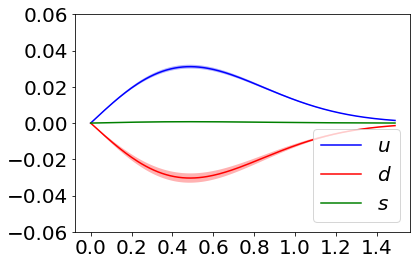

In [219]:
plotSivDistBands(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100)

In [228]:
def plotSivDistBandsSea(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$\\bar{u}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$\\bar{d}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$\\bar{s}$')
    
#     plt.legend()
#     plt.title('Hermes 2009')
#     plt.xlabel('$k_{\perp}$')
#     plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
#     plt.savefig('2009HermesUDSsea.pdf', format='pdf', bbox_inches='tight')
    #plt.figure(figsize=(15,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.006,0.006)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig('SiversAntiQ_SIDIS_NN.pdf', format='pdf', bbox_inches='tight')

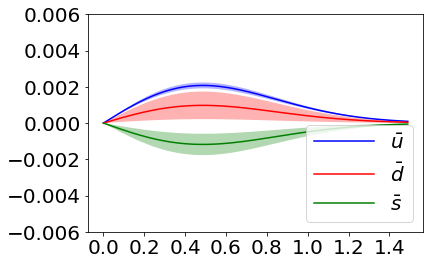

In [229]:
plotSivDistBandsSea(10, .1, 2.4, .57, -2, np.array(list(range(150)))/100)